### loading packages

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import matplotlib as mp
import os
pd.options.display.float_format = '{:.2f}'.format
from prophet import Prophet
from croston import croston
import statsmodels.api as sm
# import plotly
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error,r2_score
from pmdarima.arima.utils import ndiffs
from NBEATS import NeuralBeats
from pandas import DataFrame
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
import calendar
from datetime import timedelta
import datetime as dt
#import time

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### loading dataset

In [2]:
from autots.models.model_list import model_lists

### list of auto ts models

In [38]:
model_lists['best']

['SeasonalNaive',
 'PytorchForecasting',
 'UnivariateMotif',
 'GluonTS',
 'MetricMotif',
 'DatepartRegression',
 'ConstantNaive',
 'ARDL',
 'SectionalMotif',
 'RRVAR',
 'FFT',
 'GLM',
 'LastValueNaive',
 'MultivariateRegression',
 'GLS',
 'ARCH',
 'SeasonalityMotif',
 'WindowRegression',
 'ETS',
 'BallTreeMultivariateMotif',
 'Cassandra',
 'FBProphet',
 'VAR',
 'AverageValueNaive']

In [2]:
from autots.datasets import load_monthly
df_raw = load_monthly(long=True)

In [38]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4099 entries, 0 to 4098
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     4099 non-null   datetime64[ns]
 1   value        3955 non-null   float64       
 2   series_id    4099 non-null   object        
 3   series_name  4099 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 128.2+ KB


In [39]:
df_raw.describe()

,datetime,value
count,4099,3955.00
mean,1998-05-20 14:25:58.038545920,33.15
min,1953-04-01 00:00:00,0.25
25%,1988-10-01 00:00:00,2.01
50%,2000-10-01 00:00:00,7.74
75%,2010-06-01 00:00:00,45.57
max,2019-12-01 00:00:00,245.13
std,NaN,49.29


### data preparation to test train sets and fill na and index date time

In [3]:
def data_preparation(df,n_split,date_column="datetime",freq_input='MS'):
    
    #convert long to wide if at all
    df = df.pivot(index='datetime',columns='series_id',values='value').fillna(0)
    df.reset_index(inplace=True)

    df=df[df.loc[:,date_column].notnull()] ## selecting all rows that has date values only
    # df.columns=['date','value'] ##renaming the columns to date and value
    
    
    #date missing value imputation:
    start_date = df[date_column].min()
    end_date = df[date_column].max()


    complete_date_range = pd.date_range(start=start_date, end=end_date, freq=freq_input)
    complete_date_range = pd.Series(complete_date_range,name=date_column)
    df_complete = pd.DataFrame(complete_date_range).merge(df,on=[date_column],how='left')


    #value missing imputation
    df_complete=df_complete.fillna(0) 
    # frwd fill or backwd fill use:  df.fillna(method='ffill', inplace=True), fillna(method='bfill', inplace=True),
    # fillna(df['column3'].mean(), inplace=True)

    df_complete.index=pd.to_datetime(df_complete.loc[:,date_column])
    df_complete = df_complete.drop(columns=date_column)
    df_complete.index = pd.DatetimeIndex(df_complete.index.values,
                                   freq=df_complete.index.inferred_freq)
    ##drop na rows to get first and last values in data
    df_complete=df_complete.dropna()
    
    ## splitting data from last only
    df_test=df_complete.tail(n_split)
    df_train=df_complete[0:len(df)-n_split]
    print("pre processing done!")
    return(df_complete,df_train,df_test)

In [4]:
df_total,df_train,df_test=data_preparation(df_raw,6,'datetime','MS')
df_train

pre processing done!


,CSUSHPISA,EMVOVERALLEMV,EXCAUS,EXCHUS,EXUSEU,GS10,MCOILWTICO,T10YIEM,USEPUINDXM
1953-04-01,0.00,0.00,0.00,0.00,0.00,2.83,0.00,0.00,0.00
1953-05-01,0.00,0.00,0.00,0.00,0.00,3.05,0.00,0.00,0.00
1953-06-01,0.00,0.00,0.00,0.00,0.00,3.11,0.00,0.00,0.00
1953-07-01,0.00,0.00,0.00,0.00,0.00,2.93,0.00,0.00,0.00
1953-08-01,0.00,0.00,0.00,0.00,0.00,2.95,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...
2019-02-01,207.13,16.68,1.32,6.74,1.13,2.68,54.95,1.88,106.90
2019-03-01,207.69,20.77,1.34,6.71,1.13,2.57,58.15,1.91,140.25
2019-04-01,208.29,18.81,1.34,6.72,1.12,2.53,63.86,1.94,98.74
2019-05-01,208.73,19.53,1.35,6.85,1.12,2.40,60.83,1.83,122.54


### outlier detection

In [ ]:
# for column in df_total.columns:
#     if df_total[column].dtype in [float,int]:
#         ts = df_total[column]
#         z_scores = (ts - ts.mean()) / ts.std()
#         outliers = ts[np.abs(z_scores) > 3]  # Adjust threshold as needed

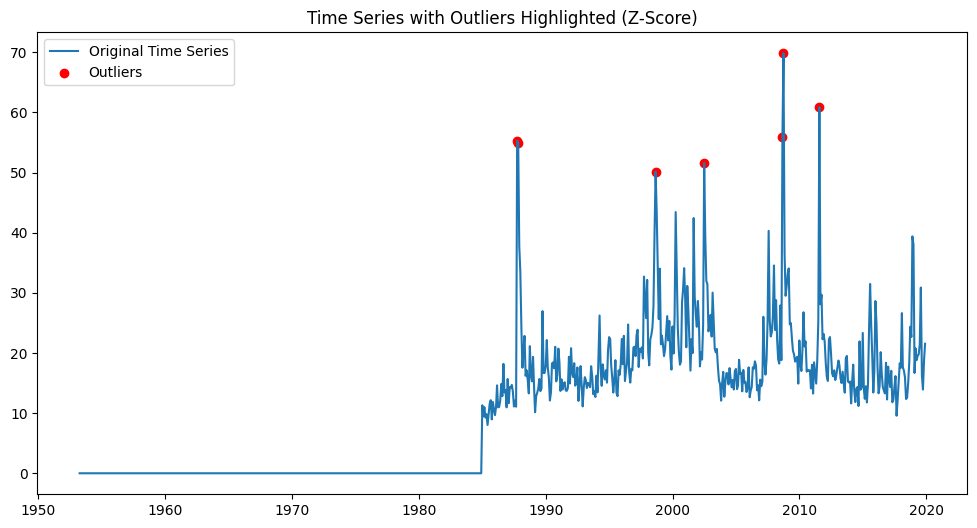

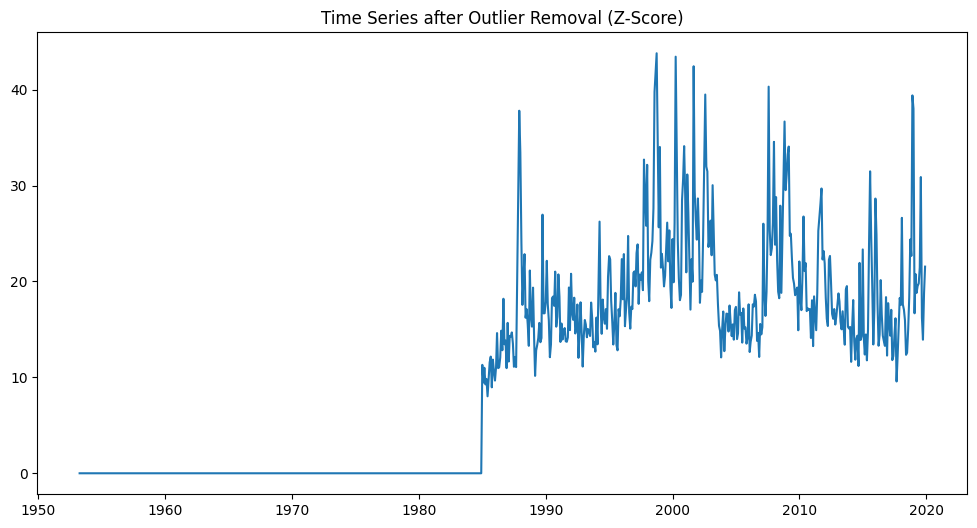

In [44]:
ts = df_total['EMVOVERALLEMV']
z_scores = (ts - ts.mean()) / ts.std()
outliers = ts[np.abs(z_scores) > 3] 


## plot outliers along on original dataset
plt.figure(figsize=(12, 6))
plt.plot(ts, label="Original Time Series")
plt.scatter(outliers.index, outliers, color="red", label="Outliers")
plt.legend()
plt.title("Time Series with Outliers Highlighted (Z-Score)")
plt.show()

## outlier removal
ts_clean = ts[np.abs(z_scores) <= 3]

plt.figure(figsize=(12, 6))
plt.plot(ts_clean, label="Time Series without Outliers")
plt.title("Time Series after Outlier Removal (Z-Score)")
plt.show()

###  data time series plots : data plot, acf, pacf, 

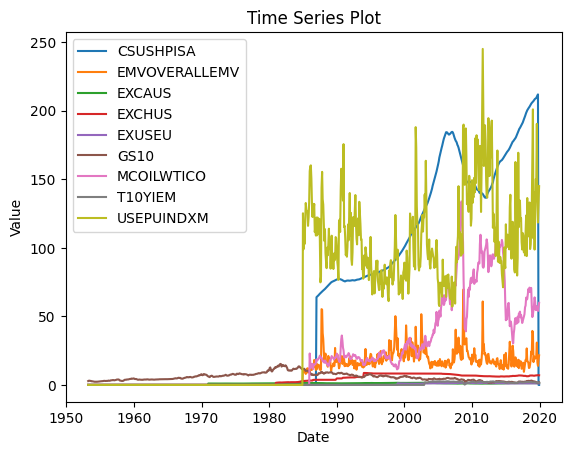

In [43]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))

for column in df_total.columns:
    if df_total[column].dtype in [float,int]:
        plt.plot(df_total.index, df_total[column], label=column)
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

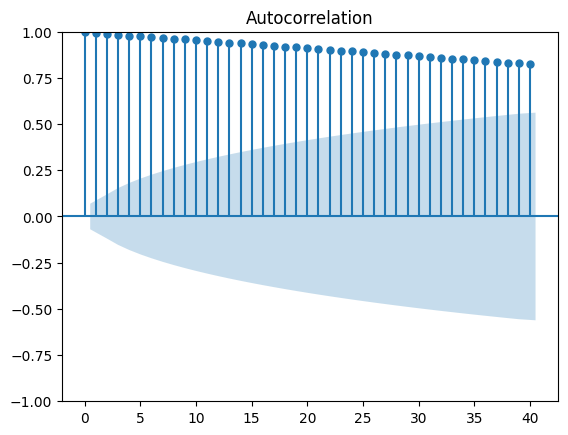

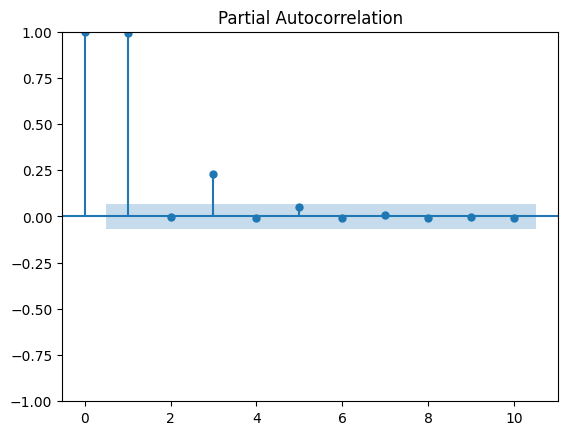

In [91]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_total.iloc[:,0], lags=40) 
plot_pacf(df_total.iloc[:,0], lags=10)

plt.show()

### ADF test for stationarity

In [5]:
from statsmodels.tsa.stattools import adfuller
adf=adfuller(df_total.iloc[:,0])
# test stat, pval < 0.05 then stationary else non stationary
print(adf)

(-1.569419646486478, 0.4989343382503163, 0, 800, {'1%': -3.438550508267578, '5%': -2.8651595688281253, '10%': -2.5686973890625}, 5443.097322367612)


## Modelling

In [ ]:
mod_ses = sm.tsa.statespace.ExponentialSmoothing(df_train)
ses=mod_ses.fit()
forecast_ses=ses.forecast(6)

In [94]:
# for long format


# from autots import AutoTS

# auto_model=AutoTS(3,"infer",max_generations=5,no_negatives=True,ensemble='simple')
# auto_model = auto_model.fit(
#     df_train,date_col='datetime',value_col='value',id_col='series_id'
# )
# prediction=auto_model.predict()
# forecasts_df = prediction.forecast

In [7]:
long=False
from autots import AutoTS


model = AutoTS(
    forecast_length=6,
    frequency='infer',
    prediction_interval=0.9,
    ensemble='horizontal',
    model_list= 'best', #"multivariate",  # "superfast", "default", "fast_parallel"
    transformer_list="fast",  # "superfast",
    max_generations=4,
    num_validations=2,
    validation_method="backwards"
)
model.fit(
    df_train,
    date_col='datetime' if long else None,
    value_col='value' if long else None,
    id_col='series_id' if long else None,
)

prediction = model.predict()

Data frequency is: MS, used frequency is: MS
Model Number: 1 with model AverageValueNaive in generation 0 of 4
Model Number: 2 with model AverageValueNaive in generation 0 of 4
Model Number: 3 with model AverageValueNaive in generation 0 of 4
Model Number: 4 with model DatepartRegression in generation 0 of 4
Model Number: 5 with model DatepartRegression in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/

Model Number: 6 with model DatepartRegression in generation 0 of 4
Model Number: 7 with model DatepartRegression in generation 0 of 4
Template Eval Error: ImportError('Tensorflow not available, install with pip install tensorflow.') in model 7 in generation 0: DatepartRegression
Model Number: 8 with model ETS in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 9 with model ETS in generation 0 of 4
Model Number: 10 with model GLM in generation 0 of 4
Model Number: 11 with model GLM in generation 0 of 4
Model Number: 12 with model GLS in generation 0 of 4
Model Number: 13 with model GLS in generation 0 of 4
Model Number: 14 with model GluonTS in generation 0 of 4
Template Eval Error: ModuleNotFoundError("No module named 'lightning'") in model 14 in generation 0: GluonTS
Model Number: 15 with model GluonTS in generation 0 of 4
Template Eval Error: ImportError("cannot import name 'NPTSEstimator' from 'gluonts.model.npts' (/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/model/npts/__init__.py)") in model 15 in generation 0: GluonTS
Model Number: 16 with model GluonTS in generation 0 of 4
Template Eval Error: ModuleNotFoundError("No module named 'gluonts.model.wavenet'") in model 16 in generation 0: GluonTS
Model Number: 17 with model GluonTS in generation 0 of 4
Template Eval Error: ModuleNotFoundError("

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 30 with model FBProphet in generation 0 of 4


19:57:40 - cmdstanpy - INFO - Chain [1] start processing
19:57:40 - cmdstanpy - INFO - Chain [1] start processing
19:57:40 - cmdstanpy - INFO - Chain [1] start processing
19:57:40 - cmdstanpy - INFO - Chain [1] start processing
19:57:40 - cmdstanpy - INFO - Chain [1] start processing
19:57:40 - cmdstanpy - INFO - Chain [1] start processing
19:57:40 - cmdstanpy - INFO - Chain [1] start processing
19:57:40 - cmdstanpy - INFO - Chain [1] start processing
19:57:40 - cmdstanpy - INFO - Chain [1] start processing
19:57:40 - cmdstanpy - INFO - Chain [1] done processing
19:57:40 - cmdstanpy - INFO - Chain [1] done processing
19:57:40 - cmdstanpy - INFO - Chain [1] done processing
19:57:40 - cmdstanpy - INFO - Chain [1] done processing
19:57:40 - cmdstanpy - INFO - Chain [1] done processing
19:57:40 - cmdstanpy - INFO - Chain [1] done processing
19:57:40 - cmdstanpy - INFO - Chain [1] done processing
19:57:40 - cmdstanpy - INFO - Chain [1] done processing
19:57:40 - cmdstanpy - INFO - Chain [1]

Model Number: 31 with model GluonTS in generation 0 of 4
Template Eval Error: ModuleNotFoundError("No module named 'gluonts.model.transformer'") in model 31 in generation 0: GluonTS
Model Number: 32 with model MultivariateRegression in generation 0 of 4
Model Number: 33 with model MultivariateRegression in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 33 in generation 0: MultivariateRegression
Model Number: 34 with model DatepartRegression in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 34 in generation 0: DatepartRegression
Model Number: 35 with model SeasonalNaive in generation 0 of 4
Model Number: 36 with model DatepartRegression in generation 0 of 4
Model Number: 37 with model ETS in generation 0 of 4
Model Number: 38 with model ARDL in generation 0 of 4
Model Number: 39 with model UnivariateMotif in generation 0 of 4
Model Number: 40 with

19:57:44 - cmdstanpy - INFO - Chain [1] start processing
19:57:44 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 46 with model DatepartRegression in generation 0 of 4
Model Number: 47 with model ARCH in generation 0 of 4
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 47 in generation 0: ARCH
Model Number: 48 with model Cassandra in generation 0 of 4
Model Number: 49 with model SeasonalityMotif in generation 0 of 4
Model Number: 50 with model Cassandra in generation 0 of 4
Model Number: 51 with model Cassandra in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarnin

Model Number: 52 with model ARCH in generation 0 of 4
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 52 in generation 0: ARCH
Model Number: 53 with model FFT in generation 0 of 4
Model Number: 54 with model SectionalMotif in generation 0 of 4
Model Number: 55 with model SeasonalityMotif in generation 0 of 4
Model Number: 56 with model AverageValueNaive in generation 0 of 4
Model Number: 57 with model ETS in generation 0 of 4
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'ffill', 'transformations': {'0': 'Detrend', '1': 'RollingMeanTransformer', '2': 'AlignLastValue'}, 'transformation_params': {'0': {'model': 'GLS', 'phi': 1, 'window': None, 'transform_dict': {'fillna': None, 'transformations': {'0': 'EWMAFilter'}, 'transformation_params': {'0': {'span': 7}}}}, '1': {'fixed': True, 'window': 12}, '2': {'rows': 1, 'lag': 1, 'method': 'multiplicative', 'strength': 0.7, 'first_value_only': False}}}.

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neighbors/_regression.py:500: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Model Number: 61 with model MultivariateRegression in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Template Eval Error: ValueError('Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.') in model 61 in generation 0: MultivariateRegression
Model Number: 62 with model PytorchForecasting in generation 0 of 4
Template Eval Error: ImportError('pytorch, pytorch lighting, or pytorch-forecasting not present') in model 62 in generation 0: PytorchForecasting
Model Number: 63 with model GLS in generation 0 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 63 in generation 0: GLS
Model Number: 64 with model RRVAR in generation 0 of 4
Model Number: 65 with model SeasonalNaive in generation 0 of 4
Model Number: 66 with model FBProphet in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Number: 67 with model ConstantNaive in generation 0 of 4
Template Eval Error: Exception('Transformer RobustScaler failed on fit') in model 67 in generation 0: ConstantNaive
Model Number: 68 with model GluonTS in generation 0 of 4
Template Eval Error: ModuleNotFoundError("No module named 'gluonts.model.seq2seq'") in model 68 in generation 0: GluonTS
Model Number: 69 with model GLM in generation 0 of 4
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 69 in generation 0: GLM
Model Number: 70 with model Cassandra in generation 0 of 4
Template Eval Error: Exception('Transformer MinMaxScaler failed on fit') in model 70 in generation 0: Cassandra
Model Number: 71 with model WindowRegression in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warn

Model Number: 72 with model LastValueNaive in generation 0 of 4
Model Number: 73 with model MetricMotif in generation 0 of 4
Model Number: 74 with model BallTreeMultivariateMotif in generation 0 of 4
Template Eval Error: ValueError("Unrecognized metric '['kdtree']'") in model 74 in generation 0: BallTreeMultivariateMotif
Model Number: 75 with model UnivariateMotif in generation 0 of 4
Model Number: 76 with model RRVAR in generation 0 of 4
Model Number: 77 with model UnivariateMotif in generation 0 of 4
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 77 in generation 0: UnivariateMotif
Model Number: 78 with model MultivariateRegression in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 79 with model FFT in generation 0 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 79 in generation 0: FFT
Model Number: 80 with model ConstantNaive in generation 0 of 4
Model Number: 81 with model BallTreeMultivariateMotif in generation 0 of 4
Template Eval Error: ValueError("Unrecognized metric '['euclidean']'") in model 81 in generation 0: BallTreeMultivariateMotif
Model Number: 82 with model ARCH in generation 0 of 4
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 82 in generation 0: ARCH
Model Number: 83 with model WindowRegression in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 84 with model AverageValueNaive in generation 0 of 4
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 84 in generation 0: AverageValueNaive
Model Number: 85 with model PytorchForecasting in generation 0 of 4
Template Eval Error: ImportError('pytorch, pytorch lighting, or pytorch-forecasting not present') in model 85 in generation 0: PytorchForecasting
Model Number: 86 with model ARDL in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 86 in generation 0: ARDL
Model Number: 87 with model FFT in generation 0 of 4
Model Number: 88 with model FFT in generation 0 of 4
Model Number: 89 with model ETS in generation 0 of 4
Model Number: 90 with model WindowRegression in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Model Number: 91 with model FBProphet in generation 0 of 4


20:00:53 - cmdstanpy - INFO - Chain [1] start processing
20:00:53 - cmdstanpy - INFO - Chain [1] start processing
20:00:53 - cmdstanpy - INFO - Chain [1] start processing
20:00:53 - cmdstanpy - INFO - Chain [1] start processing
20:00:53 - cmdstanpy - INFO - Chain [1] start processing
20:00:53 - cmdstanpy - INFO - Chain [1] start processing
20:00:53 - cmdstanpy - INFO - Chain [1] start processing
20:00:53 - cmdstanpy - INFO - Chain [1] start processing
20:00:53 - cmdstanpy - INFO - Chain [1] done processing
20:00:53 - cmdstanpy - INFO - Chain [1] done processing
20:00:54 - cmdstanpy - INFO - Chain [1] done processing
20:00:54 - cmdstanpy - INFO - Chain [1] done processing
20:00:54 - cmdstanpy - INFO - Chain [1] done processing
20:00:54 - cmdstanpy - INFO - Chain [1] done processing
20:00:54 - cmdstanpy - INFO - Chain [1] done processing
20:00:54 - cmdstanpy - INFO - Chain [1] done processing
20:00:54 - cmdstanpy - INFO - Chain [1] start processing
20:00:54 - cmdstanpy - INFO - Chain [1]

Model Number: 92 with model FBProphet in generation 0 of 4
Model Number: 93 with model WindowRegression in generation 0 of 4
Template Eval Error: ValueError('Model WindowRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 93 in generation 0: WindowRegression
Model Number: 94 with model UnivariateMotif in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neighbors/_regression.py:500: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Model Number: 95 with model BallTreeMultivariateMotif in generation 0 of 4
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 95 in generation 0: BallTreeMultivariateMotif
Model Number: 96 with model MetricMotif in generation 0 of 4
Model Number: 97 with model ARCH in generation 0 of 4
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 97 in generation 0: ARCH
Model Number: 98 with model DatepartRegression in generation 0 of 4
Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 98 in generation 0: DatepartRegression
Model Number: 99 with model Cassandra in generation 0 of 4
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 99 in generation 0: Cassandra
Model Number: 100 with model SeasonalNaive in generation 0 of 4
Model Number: 101 with model PytorchForecasting in generation 0 of 4
Template Eval Error: Impo

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neighbors/_regression.py:500: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Model Number: 105 with model ConstantNaive in generation 0 of 4
Model Number: 106 with model FBProphet in generation 0 of 4
Model Number: 107 with model MultivariateRegression in generation 0 of 4
Model Number: 108 with model MultivariateRegression in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 108 in generation 0: MultivariateRegression
Model Number: 109 with model ARCH in generation 0 of 4
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 109 in generation 0: ARCH
Model Number: 110 with model PytorchForecasting in generation 0 of 4
Template Eval Error: ImportError('pytorch, pytorch lighting, or pytorch-forecasting not present') in model 110 in generation 0: PytorchForecasting
Model Number: 111 with model WindowRegression in generation 0 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 111 in generation 0: WindowRegression
Model N

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 117 with model SeasonalityMotif in generation 0 of 4
Model Number: 118 with model UnivariateMotif in generation 0 of 4
Model Number: 119 with model ConstantNaive in generation 0 of 4
Model Number: 120 with model SeasonalNaive in generation 0 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 120 in generation 0: SeasonalNaive
Model Number: 121 with model RRVAR in generation 0 of 4
Model Number: 122 with model SeasonalNaive in generation 0 of 4
Model Number: 123 with model SeasonalNaive in generation 0 of 4
Model Number: 124 with model LastValueNaive in generation 0 of 4
Model Number: 125 with model ARCH in generation 0 of 4
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 125 in generation 0: ARCH
Model Number: 126 with model SeasonalityMotif in generation 0 of 4
Model Number: 127 with model GLS in generation 0 of 4
Model Number: 128 with model RRVAR in generation 0 of 4
Model Number: 129 with

20:00:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
20:00:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
20:00:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:00:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:00:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:00:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:00:58 - cmdstanpy - INFO - Chain [1] start processing
20:00:5

Model Number: 130 with model FFT in generation 0 of 4
Model Number: 131 with model WindowRegression in generation 0 of 4


20:01:07 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 132 with model FBProphet in generation 0 of 4


20:01:08 - cmdstanpy - INFO - Chain [1] start processing


Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 132 in generation 0: FBProphet
Model Number: 133 with model RRVAR in generation 0 of 4


20:01:08 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 134 with model BallTreeMultivariateMotif in generation 0 of 4
Template Eval Error: ValueError("Unrecognized metric '['minkowski']'") in model 134 in generation 0: BallTreeMultivariateMotif
Model Number: 135 with model BallTreeMultivariateMotif in generation 0 of 4
Template Eval Error: ValueError("Unrecognized metric '['euclidean']'") in model 135 in generation 0: BallTreeMultivariateMotif
Model Number: 136 with model GluonTS in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 136 in generation 0: GluonTS
Model Number: 137 with model ARCH in generation 0 of 4
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 137 in generation 0: ARCH
Model Number: 138 with model ConstantNaive in generation 0 of 4
Model Number: 139 with model Cassandra in generation 0 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 139 in generation 0: Cassandra
Model Number: 140 with model DatepartRegression in generation 0 of 4
Model Number: 141 with model GluonTS in generation 0 of 4
Template Eval Error: ModuleNotFoundError("No module named 'gluonts.model.wavenet'") in model 141 in generation 0: GluonTS
Model Number: 142 with model SeasonalNaive in generation 0 of 4
Model Number: 143 with model AverageValueNaive in generation 0 of 4
Model Number: 144 with model UnivariateMotif in generation 0 of 4
Model Number: 145 with model FFT in generation 0 of 4
Model Number: 146 with model GLS in generation 0 of 4
Model Number: 147 with model PytorchForecasting in generation 0 of 4
Template Eval Error: ImportError('pytorch, pytorch lighting, or pytorch-forecasting not present') in model 147 in generation 0: PytorchForecasting
Model Number: 148 with model MetricMotif in generation 0 of 4
Model Number: 149 with model ARCH in generation 

20:01:13 - cmdstanpy - INFO - Chain [1] start processing


Model Number: 158 with model ConstantNaive in generation 0 of 4
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 158 in generation 0: ConstantNaive
Model Number: 159 with model SeasonalityMotif in generation 0 of 4


20:01:13 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 160 with model BallTreeMultivariateMotif in generation 0 of 4
Template Eval Error: ValueError("Unrecognized metric '['canberra']'") in model 160 in generation 0: BallTreeMultivariateMotif
Model Number: 161 with model ETS in generation 0 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 161 in generation 0: ETS
Model Number: 162 with model Cassandra in generation 0 of 4
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 162 in generation 0: Cassandra
Model Number: 163 with model FBProphet in generation 0 of 4
Model Number: 164 with model RRVAR in generation 0 of 4
Model Number: 165 with model MultivariateRegression in generation 0 of 4
Model Number: 166 with model VAR in generation 0 of 4
Model Number: 167 with model ARDL in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 167 in generation 0: ARDL
Model Number: 168 with model LastV

20:01:20 - cmdstanpy - INFO - Chain [1] start processing
20:01:20 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 178 with model UnivariateMotif in generation 1 of 4
Model Number: 179 with model UnivariateMotif in generation 1 of 4
Model Number: 180 with model WindowRegression in generation 1 of 4
Model Number: 181 with model SectionalMotif in generation 1 of 4
Model Number: 182 with model SeasonalNaive in generation 1 of 4
Model Number: 183 with model FFT in generation 1 of 4
Model Number: 184 with model UnivariateMotif in generation 1 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 185 with model VAR in generation 1 of 4
Model Number: 186 with model SeasonalityMotif in generation 1 of 4
Model Number: 187 with model SeasonalityMotif in generation 1 of 4
Model Number: 188 with model SeasonalityMotif in generation 1 of 4
Model Number: 189 with model RRVAR in generation 1 of 4
Model Number: 190 with model VAR in generation 1 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 190 in generation 1: VAR
Model Number: 191 with model SectionalMotif in generation 1 of 4
Model Number: 192 with model ConstantNaive in generation 1 of 4
Model Number: 193 with model VAR in generation 1 of 4
Template Eval Error: ValueError('maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.') in model 193 in generation 1: VAR
Model Number: 194 with model MetricMotif in generation 1 of 4
Model Number: 195 with model VAR in generation 1 of 4
Model Number: 196 with model Avera

20:01:26 - cmdstanpy - INFO - Chain [1] start processing
20:01:26 - cmdstanpy - INFO - Chain [1] done processing
20:01:26 - cmdstanpy - INFO - Chain [1] start processing
20:01:27 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 199 with model SeasonalityMotif in generation 1 of 4
Model Number: 200 with model GLM in generation 1 of 4
Model Number: 201 with model SeasonalNaive in generation 1 of 4
Model Number: 202 with model UnivariateMotif in generation 1 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 203 with model LastValueNaive in generation 1 of 4
Model Number: 204 with model LastValueNaive in generation 1 of 4
Model Number: 205 with model MultivariateRegression in generation 1 of 4
Model Number: 206 with model AverageValueNaive in generation 1 of 4
Model Number: 207 with model FFT in generation 1 of 4
Model Number: 208 with model SeasonalityMotif in generation 1 of 4
Model Number: 209 with model LastValueNaive in generation 1 of 4
Model Number: 210 with model SeasonalNaive in generation 1 of 4
Model Number: 211 with model LastValueNaive in generation 1 of 4
Model Number: 212 with model GLS in generation 1 of 4
Model Number: 213 with model FBProphet in generation 1 of 4
Model Number: 214 with model VAR in generation 1 of 4
Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 214 in generation 1: VAR
Model Number: 215 with model LastValueNaive in generation 1 of 4
Model Number: 216 with model LastValueNaive in generation 1 of 4

20:01:29 - cmdstanpy - INFO - Chain [1] start processing
20:01:29 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 220 with model Cassandra in generation 1 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 220 in generation 1: Cassandra
Model Number: 221 with model FBProphet in generation 1 of 4
Model Number: 222 with model SectionalMotif in generation 1 of 4


20:01:32 - cmdstanpy - INFO - Chain [1] start processing
20:01:32 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 223 with model MultivariateRegression in generation 1 of 4
Model Number: 224 with model LastValueNaive in generation 1 of 4
Model Number: 225 with model AverageValueNaive in generation 1 of 4
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 225 in generation 1: AverageValueNaive
Model Number: 226 with model RRVAR in generation 1 of 4
Model Number: 227 with model FBProphet in generation 1 of 4
Model Number: 228 with model ETS in generation 1 of 4
Model Number: 229 with model UnivariateMotif in generation 1 of 4
Model Number: 230 with model GLS in generation 1 of 4
Model Number: 231 with model SectionalMotif in generation 1 of 4
Model Number: 232 with model RRVAR in generation 1 of 4
Model Number: 233 with model WindowRegression in generation 1 of 4
Model Number: 234 with model MultivariateRegression in generation 1 of 4
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 234 in generation 1: 

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
20:01:34 - cmdstanpy - INFO - Chain [1] start processing
20:01:34 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 239 with model UnivariateMotif in generation 1 of 4
Model Number: 240 with model AverageValueNaive in generation 1 of 4
Model Number: 241 with model WindowRegression in generation 1 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 241 in generation 1: WindowRegression
Model Number: 242 with model SectionalMotif in generation 1 of 4
Model Number: 243 with model MultivariateRegression in generation 1 of 4
Template Eval Error: Exception('Transformer RobustScaler failed on inverse') in model 243 in generation 1: MultivariateRegression
Model Number: 244 with model SectionalMotif in generation 1 of 4
Model Number: 245 with model MetricMotif in generation 1 of 4
Model Number: 246 with model SeasonalityMotif in generation 1 of 4
Model Number: 247 with model FFT in generation 1 of 4
Model Number: 248 with model FFT in generation 1 of 4
Model Number: 249 with model UnivariateMotif in generation 1 of 4
Model Number: 250 with mode

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/autots/tools/impute.py:54: RuntimeWarning: Mean of empty slice
  arr = np.nan_to_num(arr) + np.isnan(arr) * np.nan_to_num(np.nanmean(arr, axis=0))


Model Number: 260 with model FBProphet in generation 1 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 261 with model SeasonalNaive in generation 1 of 4
Model Number: 262 with model GLS in generation 1 of 4


20:01:36 - cmdstanpy - INFO - Chain [1] start processing
20:01:36 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 263 with model VAR in generation 1 of 4
Model Number: 264 with model ConstantNaive in generation 1 of 4
Model Number: 265 with model SeasonalNaive in generation 1 of 4
Model Number: 266 with model MetricMotif in generation 1 of 4
Model Number: 267 with model VAR in generation 1 of 4
Model Number: 268 with model RRVAR in generation 1 of 4
Model Number: 269 with model MultivariateRegression in generation 1 of 4
Model Number: 270 with model DatepartRegression in generation 1 of 4
Model Number: 271 with model SeasonalityMotif in generation 1 of 4
Model Number: 272 with model LastValueNaive in generation 1 of 4
Model Number: 273 with model MultivariateRegression in generation 1 of 4
Model Number: 274 with model AverageValueNaive in generation 1 of 4
Model Number: 275 with model DatepartRegression in generation 1 of 4
Model Number: 276 with model Cassandra in generation 1 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 277 with model ConstantNaive in generation 1 of 4
Model Number: 278 with model LastValueNaive in generation 1 of 4
Model Number: 279 with model UnivariateMotif in generation 1 of 4
Model Number: 280 with model DatepartRegression in generation 1 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 280 in generation 1: DatepartRegression
Model Number: 281 with model AverageValueNaive in generation 1 of 4
Model Number: 282 with model RRVAR in generation 1 of 4
Model Number: 283 with model ETS in generation 1 of 4
Model Number: 284 with model SectionalMotif in generation 1 of 4
Model Number: 285 with model GLS in generation 1 of 4
Model Number: 286 with model UnivariateMotif in generation 1 of 4
Model Number: 287 with model VAR in generation 1 of 4
Model Number: 288 with model ConstantNaive in generation 1 of 4
Model Number: 289 with model GLS in generation 1 of 4
Model Number: 290 with model SeasonalNaive in generation 1 of 4

20:01:44 - cmdstanpy - INFO - Chain [1] start processing
20:01:44 - cmdstanpy - INFO - Chain [1] start processing
20:01:44 - cmdstanpy - INFO - Chain [1] done processing
20:01:44 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 294 with model LastValueNaive in generation 2 of 4
Model Number: 295 with model MetricMotif in generation 2 of 4
Model Number: 296 with model SeasonalityMotif in generation 2 of 4
Model Number: 297 with model VAR in generation 2 of 4
Model Number: 298 with model UnivariateMotif in generation 2 of 4
Model Number: 299 with model ConstantNaive in generation 2 of 4
Model Number: 300 with model MetricMotif in generation 2 of 4
Model Number: 301 with model ConstantNaive in generation 2 of 4
Model Number: 302 with model SectionalMotif in generation 2 of 4
Model Number: 303 with model FBProphet in generation 2 of 4
Model Number: 304 with model AverageValueNaive in generation 2 of 4
Model Number: 305 with model VAR in generation 2 of 4
Model Number: 306 with model UnivariateMotif in generation 2 of 4
Model Number: 307 with model SeasonalNaive in generation 2 of 4
Model Number: 308 with model Cassandra in generation 2 of 4
Model Number: 309 with model FBProphet in generation 2 of 4

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
20:01:47 - cmdstanpy - INFO - Chain [1] start processing
20:01:47 - cmdstanpy - INFO - Chain [1] start processing
20:01:47 - cmdstanpy - INFO - Chain [1] done processing
20:01:47 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 310 with model LastValueNaive in generation 2 of 4
Model Number: 311 with model ConstantNaive in generation 2 of 4
Model Number: 312 with model SeasonalNaive in generation 2 of 4
Model Number: 313 with model WindowRegression in generation 2 of 4
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 313 in generation 2: WindowRegression
Model Number: 314 with model VAR in generation 2 of 4
Model Number: 315 with model SectionalMotif in generation 2 of 4
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 315 in generation 2: SectionalMotif
Model Number: 316 with model ConstantNaive in generation 2 of 4
Model Number: 317 with model ETS in generation 2 of 4
Model Number: 318 with model VAR in generation 2 of 4
Model Number: 319 with model Cassandra in generation 2 of 4
Template Eval Error: ValueError('The covariance matrix of the support data is equal to 0, try to increase support_fraction') in model 319 in generation 2: Ca

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 322 with model AverageValueNaive in generation 2 of 4
Model Number: 323 with model MetricMotif in generation 2 of 4
Model Number: 324 with model UnivariateMotif in generation 2 of 4
Model Number: 325 with model FBProphet in generation 2 of 4
Template Eval Error: Exception('Transformer PowerTransformer failed on inverse') in model 325 in generation 2: FBProphet
Model Number: 326 with model ConstantNaive in generation 2 of 4
Model Number: 327 with model WindowRegression in generation 2 of 4
Model Number: 328 with model RRVAR in generation 2 of 4
Model Number: 329 with model Cassandra in generation 2 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 330 with model FFT in generation 2 of 4
Model Number: 331 with model Cassandra in generation 2 of 4
Model Number: 332 with model FBProphet in generation 2 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
20:01:56 - cmdstanpy - INFO - Chain [1] start processing
20:01:57 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 333 with model SeasonalNaive in generation 2 of 4
Model Number: 334 with model UnivariateMotif in generation 2 of 4
Model Number: 335 with model VAR in generation 2 of 4
Template Eval Error: LinAlgError('18-th leading minor of the array is not positive definite') in model 335 in generation 2: VAR
Model Number: 336 with model VAR in generation 2 of 4
Model Number: 337 with model DatepartRegression in generation 2 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 337 in generation 2: DatepartRegression
Model Number: 338 with model ETS in generation 2 of 4
Model Number: 339 with model AverageValueNaive in generation 2 of 4
Model Number: 340 with model SeasonalityMotif in generation 2 of 4
Model Number: 341 with model VAR in generation 2 of 4
Model Number: 342 with model SectionalMotif in generation 2 of 4
Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 342 in generation 2: Sectio

[LightGBM] [Fatal] [tweedie]: at least one target label is negative
[LightGBM] [Fatal] [tweedie]: at least one target label is negative
[LightGBM] [Fatal] [tweedie]: at least one target label is negative
[LightGBM] [Fatal] [tweedie]: at least one target label is negative
[LightGBM] [Fatal] [tweedie]: at least one target label is negative
20:02:01 - cmdstanpy - INFO - Chain [1] start processing
20:02:01 - cmdstanpy - INFO - Chain [1] done processing
20:02:01 - cmdstanpy - INFO - Chain [1] start processing
20:02:01 - cmdstanpy - INFO - Chain [1] start processing
20:02:01 - cmdstanpy - INFO - Chain [1] done processing
20:02:01 - cmdstanpy - INFO - Chain [1] start processing
20:02:01 - cmdstanpy - INFO - Chain [1] start processing
20:02:01 - cmdstanpy - INFO - Chain [1] start processing
20:02:01 - cmdstanpy - INFO - Chain [1] start processing
20:02:01 - cmdstanpy - INFO - Chain [1] start processing
20:02:01 - cmdstanpy - INFO - Chain [1] start processing
20:02:01 - cmdstanpy - INFO - Chain

Model Number: 364 with model GLS in generation 2 of 4
Model Number: 365 with model Cassandra in generation 2 of 4
Model Number: 366 with model VAR in generation 2 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 367 with model FBProphet in generation 2 of 4
Model Number: 368 with model AverageValueNaive in generation 2 of 4
Model Number: 369 with model SeasonalNaive in generation 2 of 4
Model Number: 370 with model MultivariateRegression in generation 2 of 4
Model Number: 371 with model AverageValueNaive in generation 2 of 4
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 371 in generation 2: AverageValueNaive
Model Number: 372 with model GLS in generation 2 of 4
Model Number: 373 with model GLM in generation 2 of 4
Model Number: 374 with model WindowRegression in generation 2 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 374 in generation 2: WindowRegression
Model Number: 375 with model SectionalMotif in generation 2 of 4
Model Number: 376 with model RRVAR in generation 2 of 4
Model Number: 377 with model SectionalMotif in generation 2 of 4
Model Number: 378 with model SeasonalNaive in gene

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 392 with model GLM in generation 2 of 4
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 392 in generation 2: GLM
Model Number: 393 with model GLS in generation 2 of 4
Model Number: 394 with model Cassandra in generation 2 of 4
Model Number: 395 with model VAR in generation 2 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/fo

Model Number: 396 with model SectionalMotif in generation 2 of 4
Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 396 in generation 2: SectionalMotif
Model Number: 397 with model Cassandra in generation 2 of 4
Model Number: 398 with model ETS in generation 2 of 4
Model Number: 399 with model AverageValueNaive in generation 2 of 4
Model Number: 400 with model Cassandra in generation 2 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 401 with model MetricMotif in generation 2 of 4
Model Number: 402 with model SectionalMotif in generation 2 of 4
Model Number: 403 with model UnivariateMotif in generation 2 of 4
Model Number: 404 with model AverageValueNaive in generation 2 of 4
Model Number: 405 with model FFT in generation 2 of 4
Model Number: 406 with model ETS in generation 2 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 406 in generation 2: ETS
Model Number: 407 with model LastValueNaive in generation 2 of 4
Model Number: 408 with model UnivariateMotif in generation 2 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 408 in generation 2: UnivariateMotif
Model Number: 409 with model LastValueNaive in generation 2 of 4
Model Number: 410 with model MultivariateRegression in generation 2 of 4
Model Number: 411 with model FFT in generation 2 of 4
Template Eval Error: Exception('Transformer PowerTransformer failed on

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 413 with model FFT in generation 3 of 4
Model Number: 414 with model SeasonalityMotif in generation 3 of 4
Model Number: 415 with model GLS in generation 3 of 4
Model Number: 416 with model UnivariateMotif in generation 3 of 4
Model Number: 417 with model RRVAR in generation 3 of 4
Model Number: 418 with model ARDL in generation 3 of 4
Model Number: 419 with model SeasonalityMotif in generation 3 of 4
Model Number: 420 with model DatepartRegression in generation 3 of 4
Template Eval Error: ImportError('Tensorflow not available, install with pip install tensorflow.') in model 420 in generation 3: DatepartRegression
Model Number: 421 with model SeasonalNaive in generation 3 of 4
Model Number: 422 with model GLS in generation 3 of 4
Model Number: 423 with model ETS in generation 3 of 4
Model Number: 424 with model SeasonalNaive in generation 3 of 4
Model Number: 425 with model VAR in generation 3 of 4
Model Number: 426 with model SeasonalityMotif in generation 3 of 4
Model N

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 437 with model SectionalMotif in generation 3 of 4
Model Number: 438 with model FBProphet in generation 3 of 4


20:02:16 - cmdstanpy - INFO - Chain [1] start processing
20:02:16 - cmdstanpy - INFO - Chain [1] done processing
20:02:16 - cmdstanpy - INFO - Chain [1] start processing
20:02:16 - cmdstanpy - INFO - Chain [1] start processing
20:02:16 - cmdstanpy - INFO - Chain [1] done processing
20:02:16 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 439 with model GLM in generation 3 of 4
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 439 in generation 3: GLM
Model Number: 440 with model DatepartRegression in generation 3 of 4
Template Eval Error: Exception('Transformer DatepartRegression failed on inverse') in model 440 in generation 3: DatepartRegression
Model Number: 441 with model GLS in generation 3 of 4
Model Number: 442 with model MultivariateRegression in generation 3 of 4
Template Eval Error: ValueError('Input X contains NaN.\nMLPRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.htm

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 445 with model Cassandra in generation 3 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 446 with model FFT in generation 3 of 4
Model Number: 447 with model VAR in generation 3 of 4
Model Number: 448 with model ETS in generation 3 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 448 in generation 3: ETS
Model Number: 449 with model LastValueNaive in generation 3 of 4
Model Number: 450 with model ETS in generation 3 of 4
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 450 in generation 3: ETS
Model Number: 451 with model SeasonalityMotif in generation 3 of 4
Model Number: 452 with model SectionalMotif in generation 3 of 4
Model Number: 453 with model RRVAR in generation 3 of 4
Model Number: 454 with model MultivariateRegression in generation 3 of 4
Model Number: 455 with model SectionalMotif in generation 3 of 4
Model Number: 456 with model LastValueNaive in generation 3 of 4
Model Number: 457 with model Cassandra in generation 3 of 4
Model Number: 458 with model ConstantNaive in

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 460 with model VAR in generation 3 of 4
Model Number: 461 with model FBProphet in generation 3 of 4
Model Number: 462 with model UnivariateMotif in generation 3 of 4
Model Number: 463 with model GLS in generation 3 of 4
Model Number: 464 with model VAR in generation 3 of 4
Model Number: 465 with model FBProphet in generation 3 of 4
Model Number: 466 with model ConstantNaive in generation 3 of 4
Model Number: 467 with model UnivariateMotif in generation 3 of 4
Model Number: 468 with model LastValueNaive in generation 3 of 4
Model Number: 469 with model SectionalMotif in generation 3 of 4
Model Number: 470 with model VAR in generation 3 of 4
Model Number: 471 with model RRVAR in generation 3 of 4
Model Number: 472 with model RRVAR in generation 3 of 4
Model Number: 473 with model LastValueNaive in generation 3 of 4
Model Number: 474 with model SeasonalityMotif in generation 3 of 4
Model Number: 475 with model FBProphet in generation 3 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.3669e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 476 with model RRVAR in generation 3 of 4


20:02:24 - cmdstanpy - INFO - Chain [1] start processing
20:02:24 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 477 with model ETS in generation 3 of 4
Model Number: 478 with model MultivariateRegression in generation 3 of 4
Model Number: 479 with model AverageValueNaive in generation 3 of 4
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 479 in generation 3: AverageValueNaive
Model Number: 480 with model SeasonalityMotif in generation 3 of 4
Model Number: 481 with model ETS in generation 3 of 4
Model Number: 482 with model MultivariateRegression in generation 3 of 4
Model Number: 483 with model UnivariateMotif in generation 3 of 4
Model Number: 484 with model AverageValueNaive in generation 3 of 4
Model Number: 485 with model SeasonalNaive in generation 3 of 4
Model Number: 486 with model GLS in generation 3 of 4
Model Number: 487 with model Cassandra in generation 3 of 4
Template Eval Error: ValueError('negative dimensions are not allowed') in model 487 in generation 3: Cassandra
Model Number: 488 with model LastValueNaive in generation 3 of 4
Mod

20:02:28 - cmdstanpy - INFO - Chain [1] start processing
20:02:28 - cmdstanpy - INFO - Chain [1] done processing


Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 495 in generation 3: FBProphet
Model Number: 496 with model AverageValueNaive in generation 3 of 4


20:02:28 - cmdstanpy - INFO - Chain [1] start processing
20:02:28 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 497 with model UnivariateMotif in generation 3 of 4
Model Number: 498 with model FBProphet in generation 3 of 4
Model Number: 499 with model SeasonalityMotif in generation 3 of 4
Model Number: 500 with model FBProphet in generation 3 of 4


20:02:30 - cmdstanpy - INFO - Chain [1] start processing


Model Number: 501 with model AverageValueNaive in generation 3 of 4
Model Number: 502 with model SeasonalNaive in generation 3 of 4
Model Number: 503 with model GLM in generation 3 of 4
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 503 in generation 3: GLM
Model Number: 504 with model LastValueNaive in generation 3 of 4
Model Number: 505 with model GLS in generation 3 of 4
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 505 in generation 3: GLS
Model Number: 506 with model SectionalMotif in generation 3 of 4
Model Number: 507 with model FFT in generation 3 of 4
Model Number: 508 with model SectionalMotif in generation 3 of 4
Model Number: 509 with model AverageValueNaive in generation 3 of 4


20:02:30 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 510 with model RRVAR in generation 3 of 4
Model Number: 511 with model GLS in generation 3 of 4
Model Number: 512 with model MultivariateRegression in generation 3 of 4
Model Number: 513 with model RRVAR in generation 3 of 4
Model Number: 514 with model SectionalMotif in generation 3 of 4
Model Number: 515 with model SeasonalNaive in generation 3 of 4
Model Number: 516 with model MultivariateRegression in generation 3 of 4
Model Number: 517 with model Cassandra in generation 3 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 518 with model UnivariateMotif in generation 3 of 4
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 518 in generation 3: UnivariateMotif
Model Number: 519 with model ConstantNaive in generation 3 of 4
Model Number: 520 with model Cassandra in generation 3 of 4
Model Number: 521 with model FFT in generation 3 of 4
Model Number: 522 with model SeasonalNaive in generation 3 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 523 with model RRVAR in generation 3 of 4
Model Number: 524 with model ConstantNaive in generation 3 of 4
Model Number: 525 with model VAR in generation 3 of 4
Model Number: 526 with model WindowRegression in generation 3 of 4
Model Number: 527 with model MultivariateRegression in generation 3 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 528 with model UnivariateMotif in generation 3 of 4
Model Number: 529 with model ConstantNaive in generation 3 of 4
Model Number: 530 with model GLS in generation 3 of 4
Model Number: 531 with model MetricMotif in generation 3 of 4
New Generation: 4 of 4
Model Number: 532 with model Cassandra in generation 4 of 4
Model Number: 533 with model ConstantNaive in generation 4 of 4
Template Eval Error: Exception('Transformer StandardScaler failed on inverse') in model 533 in generation 4: ConstantNaive
Model Number: 534 with model SectionalMotif in generation 4 of 4
Model Number: 535 with model UnivariateMotif in generation 4 of 4
Model Number: 536 with model MetricMotif in generation 4 of 4
Model Number: 537 with model SectionalMotif in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 538 with model Cassandra in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 539 with model VAR in generation 4 of 4
Model Number: 540 with model Cassandra in generation 4 of 4
Model Number: 541 with model SeasonalityMotif in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 542 with model FFT in generation 4 of 4
Model Number: 543 with model RRVAR in generation 4 of 4
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 543 in generation 4: RRVAR
Model Number: 544 with model SectionalMotif in generation 4 of 4
Model Number: 545 with model FFT in generation 4 of 4
Model Number: 546 with model SectionalMotif in generation 4 of 4
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 546 in generation 4: SectionalMotif
Model Number: 547 with model ETS in generation 4 of 4
Model Number: 548 with model MultivariateRegression in generation 4 of 4
Model Number: 549 with model GLS in generation 4 of 4
Model Number: 550 with model VAR in generation 4 of 4
Model Number: 551 with model GLS in generation 4 of 4
Model Number: 552 with model AverageValueNaive in generation 4 of 4
Model Number: 553 with model RRVAR in generation 4 of 4
Model Number: 554 with model AverageValueNaive i

20:02:44 - cmdstanpy - INFO - Chain [1] start processing
20:02:44 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 571 with model VAR in generation 4 of 4
Model Number: 572 with model LastValueNaive in generation 4 of 4
Model Number: 573 with model DatepartRegression in generation 4 of 4
Model Number: 574 with model UnivariateMotif in generation 4 of 4
Model Number: 575 with model FFT in generation 4 of 4
Model Number: 576 with model FBProphet in generation 4 of 4


20:02:45 - cmdstanpy - INFO - Chain [1] start processing
20:02:45 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 577 with model RRVAR in generation 4 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 577 in generation 4: RRVAR
Model Number: 578 with model MultivariateRegression in generation 4 of 4
Model Number: 579 with model VAR in generation 4 of 4
Model Number: 580 with model FBProphet in generation 4 of 4


20:02:50 - cmdstanpy - INFO - Chain [1] start processing
20:02:50 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 581 with model MultivariateRegression in generation 4 of 4
Model Number: 582 with model SectionalMotif in generation 4 of 4
Model Number: 583 with model MultivariateRegression in generation 4 of 4
Model Number: 584 with model GLM in generation 4 of 4
Model Number: 585 with model Cassandra in generation 4 of 4
Template Eval Error: IndexError('positional indexers are out-of-bounds') in model 585 in generation 4: Cassandra
Model Number: 586 with model GLS in generation 4 of 4
Model Number: 587 with model VAR in generation 4 of 4
Model Number: 588 with model UnivariateMotif in generation 4 of 4
Model Number: 589 with model UnivariateMotif in generation 4 of 4
Model Number: 590 with model Cassandra in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 591 with model LastValueNaive in generation 4 of 4
Model Number: 592 with model GLS in generation 4 of 4
Model Number: 593 with model UnivariateMotif in generation 4 of 4
Model Number: 594 with model VAR in generation 4 of 4
Template Eval Error: Exception('Transformer StandardScaler failed on fit') in model 594 in generation 4: VAR
Model Number: 595 with model SectionalMotif in generation 4 of 4
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 595 in generation 4: SectionalMotif
Model Number: 596 with model VAR in generation 4 of 4
Model Number: 597 with model RRVAR in generation 4 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 597 in generation 4: RRVAR
Model Number: 598 with model SeasonalityMotif in generation 4 of 4
Model Number: 599 with model RRVAR in generation 4 of 4
Model Number: 600 with model LastValueNaive in generation 4 of 4
Model Number: 601 with model Cassandr

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 602 with model GLS in generation 4 of 4
Model Number: 603 with model FFT in generation 4 of 4
Model Number: 604 with model FBProphet in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.06932e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 605 with model ConstantNaive in generation 4 of 4
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 605 in generation 4: ConstantNaive
Model Number: 606 with model GLM in generation 4 of 4
Model Number: 607 with model SeasonalNaive in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion para

Model Number: 608 with model RRVAR in generation 4 of 4
Model Number: 609 with model SeasonalNaive in generation 4 of 4
Model Number: 610 with model WindowRegression in generation 4 of 4
Model Number: 611 with model VAR in generation 4 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 611 in generation 4: VAR
Model Number: 612 with model WindowRegression in generation 4 of 4
Model Number: 613 with model ETS in generation 4 of 4
Model Number: 614 with model MultivariateRegression in generation 4 of 4
Model Number: 615 with model LastValueNaive in generation 4 of 4
Model Number: 616 with model AverageValueNaive in generation 4 of 4
Model Number: 617 with model SeasonalNaive in generation 4 of 4
Model Number: 618 with model Cassandra in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 619 with model SeasonalityMotif in generation 4 of 4
Model Number: 620 with model SectionalMotif in generation 4 of 4
Model Number: 621 with model FBProphet in generation 4 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 621 in generation 4: FBProphet
Model Number: 622 with model RRVAR in generation 4 of 4
Model Number: 623 with model SectionalMotif in generation 4 of 4
Model Number: 624 with model Cassandra in generation 4 of 4


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 625 with model MetricMotif in generation 4 of 4
Model Number: 626 with model GLS in generation 4 of 4
Model Number: 627 with model UnivariateMotif in generation 4 of 4
Model Number: 628 with model UnivariateMotif in generation 4 of 4
Model Number: 629 with model VAR in generation 4 of 4
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 629 in generation 4: VAR
Model Number: 630 with model ETS in generation 4 of 4
Model Number: 631 with model ETS in generation 4 of 4
Model Number: 632 with model LastValueNaive in generation 4 of 4
Model Number: 633 with model SectionalMotif in generation 4 of 4
Model Number: 634 with model MetricMotif in generation 4 of 4
Model Number: 635 with model AverageValueNaive in generation 4 of 4
Model Number: 636 with model SeasonalityMotif in generation 4 of 4
Model Number: 637 with model Cassandra in generation 4 of 4
Model Number: 638 with model ETS in generation 4 of 4
Model Number: 639 with model Cassand

20:03:06 - cmdstanpy - INFO - Chain [1] start processing
20:03:06 - cmdstanpy - INFO - Chain [1] start processing
20:03:06 - cmdstanpy - INFO - Chain [1] start processing
20:03:06 - cmdstanpy - INFO - Chain [1] done processing
20:03:06 - cmdstanpy - INFO - Chain [1] done processing
20:03:06 - cmdstanpy - INFO - Chain [1] done processing
20:03:06 - cmdstanpy - INFO - Chain [1] start processing
20:03:06 - cmdstanpy - INFO - Chain [1] start processing
20:03:06 - cmdstanpy - INFO - Chain [1] start processing
20:03:06 - cmdstanpy - INFO - Chain [1] start processing
20:03:06 - cmdstanpy - INFO - Chain [1] done processing
20:03:06 - cmdstanpy - INFO - Chain [1] done processing
20:03:06 - cmdstanpy - INFO - Chain [1] done processing
20:03:06 - cmdstanpy - INFO - Chain [1] done processing
20:03:06 - cmdstanpy - INFO - Chain [1] start processing
20:03:06 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 646 with model RRVAR in generation 4 of 4
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 646 in generation 4: RRVAR
Model Number: 647 with model SeasonalityMotif in generation 4 of 4


20:03:06 - cmdstanpy - INFO - Chain [1] start processing
20:03:06 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 648 with model MultivariateRegression in generation 4 of 4
Model Number: 649 with model GLS in generation 4 of 4
Model Number: 650 with model SectionalMotif in generation 4 of 4
Model Number: 651 with model ConstantNaive in generation 4 of 4
Ensembling Error: NameError("name 'verbose' is not defined"): Traceback (most recent call last):
  File "/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/autots/evaluator/auto_ts.py", line 1311, in fit
    self._run_template(
  File "/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/autots/evaluator/auto_ts.py", line 2024, in _run_template
    if verbose >= 0:
NameError: name 'verbose' is not defined

Validation Round: 1
Model Number: 1 of 116 with model SectionalMotif for Validation 1
📈 1 - SectionalMotif with avg smape 9.86: 
Model Number: 2 of 116 with model VAR for Validation 1
📈 2 - VAR with avg smape 9.44: 
Model Number: 3 of 116 with model VAR for Validation 1
📈 3 - VAR with avg smape 8.96

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


4 - Cassandra with avg smape 11.77: 
Model Number: 5 of 116 with model SeasonalityMotif for Validation 1
5 - SeasonalityMotif with avg smape 9.5: 
Model Number: 6 of 116 with model VAR for Validation 1
📈 6 - VAR with avg smape 8.71: 
Model Number: 7 of 116 with model VAR for Validation 1
📈 7 - VAR with avg smape 7.95: 
Model Number: 8 of 116 with model MultivariateRegression for Validation 1
8 - MultivariateRegression with avg smape 9.67: 
Model Number: 9 of 116 with model RRVAR for Validation 1
9 - RRVAR with avg smape 10.13: 
Model Number: 10 of 116 with model SectionalMotif for Validation 1
10 - SectionalMotif with avg smape 9.53: 
Model Number: 11 of 116 with model GLS for Validation 1
11 - GLS with avg smape 10.37: 
Model Number: 12 of 116 with model SectionalMotif for Validation 1
12 - SectionalMotif with avg smape 8.9: 
Model Number: 13 of 116 with model UnivariateMotif for Validation 1
13 - UnivariateMotif with avg smape 11.18: 
Model Number: 14 of 116 with model UnivariateMoti

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


22 - Cassandra with avg smape 12.61: 
Model Number: 23 of 116 with model FBProphet for Validation 1
23 - FBProphet with avg smape 15.54: 
Model Number: 24 of 116 with model Cassandra for Validation 1
24 - Cassandra with avg smape 9.13: 
Model Number: 25 of 116 with model UnivariateMotif for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


25 - UnivariateMotif with avg smape 8.47: 
Model Number: 26 of 116 with model MultivariateRegression for Validation 1
26 - MultivariateRegression with avg smape 9.16: 
Model Number: 27 of 116 with model UnivariateMotif for Validation 1
27 - UnivariateMotif with avg smape 9.75: 
Model Number: 28 of 116 with model MetricMotif for Validation 1
28 - MetricMotif with avg smape 9.3: 
Model Number: 29 of 116 with model AverageValueNaive for Validation 1
29 - AverageValueNaive with avg smape 9.56: 
Model Number: 30 of 116 with model AverageValueNaive for Validation 1
30 - AverageValueNaive with avg smape 9.51: 
Model Number: 31 of 116 with model RRVAR for Validation 1
31 - RRVAR with avg smape 10.18: 
Model Number: 32 of 116 with model AverageValueNaive for Validation 1
32 - AverageValueNaive with avg smape 9.27: 
Model Number: 33 of 116 with model LastValueNaive for Validation 1
33 - LastValueNaive with avg smape 14.21: 
Model Number: 34 of 116 with model FBProphet for Validation 1
34 - FBPro

20:03:12 - cmdstanpy - INFO - Chain [1] start processing
20:03:12 - cmdstanpy - INFO - Chain [1] done processing


36 - GLS with avg smape 9.08: 
Model Number: 37 of 116 with model MultivariateRegression for Validation 1
37 - MultivariateRegression with avg smape 9.47: 
Model Number: 38 of 116 with model MultivariateRegression for Validation 1
38 - MultivariateRegression with avg smape 9.23: 
Model Number: 39 of 116 with model GLS for Validation 1
39 - GLS with avg smape 9.05: 
Model Number: 40 of 116 with model Cassandra for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


40 - Cassandra with avg smape 12.19: 
Model Number: 41 of 116 with model SeasonalNaive for Validation 1
41 - SeasonalNaive with avg smape 12.35: 
Model Number: 42 of 116 with model RRVAR for Validation 1
42 - RRVAR with avg smape 11.51: 
Model Number: 43 of 116 with model SeasonalNaive for Validation 1
43 - SeasonalNaive with avg smape 13.71: 
Model Number: 44 of 116 with model Cassandra for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


44 - Cassandra with avg smape 8.53: 
Model Number: 45 of 116 with model RRVAR for Validation 1
45 - RRVAR with avg smape 9.86: 
Model Number: 46 of 116 with model RRVAR for Validation 1
46 - RRVAR with avg smape 9.86: 
Model Number: 47 of 116 with model Cassandra for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


47 - Cassandra with avg smape 10.89: 
Model Number: 48 of 116 with model MultivariateRegression for Validation 1
📈 48 - MultivariateRegression with avg smape 7.63: 
Model Number: 49 of 116 with model AverageValueNaive for Validation 1
49 - AverageValueNaive with avg smape 10.25: 
Model Number: 50 of 116 with model FFT for Validation 1
50 - FFT with avg smape 9.41: 
Model Number: 51 of 116 with model GLM for Validation 1
51 - GLM with avg smape 10.05: 
Model Number: 52 of 116 with model RRVAR for Validation 1
52 - RRVAR with avg smape 8.85: 
Model Number: 53 of 116 with model SeasonalityMotif for Validation 1
53 - SeasonalityMotif with avg smape 12.49: 
Model Number: 54 of 116 with model SeasonalityMotif for Validation 1
54 - SeasonalityMotif with avg smape 14.24: 
Model Number: 55 of 116 with model SeasonalityMotif for Validation 1
55 - SeasonalityMotif with avg smape 14.24: 
Model Number: 56 of 116 with model MultivariateRegression for Validation 1
56 - MultivariateRegression with avg

20:03:17 - cmdstanpy - INFO - Chain [1] start processing
20:03:17 - cmdstanpy - INFO - Chain [1] done processing
20:03:17 - cmdstanpy - INFO - Chain [1] start processing
20:03:17 - cmdstanpy - INFO - Chain [1] done processing


59 - FBProphet with avg smape 16.5: 
Model Number: 60 of 116 with model FBProphet for Validation 1
60 - FBProphet with avg smape 10.06: 
Model Number: 61 of 116 with model SeasonalityMotif for Validation 1
61 - SeasonalityMotif with avg smape 9.66: 
Model Number: 62 of 116 with model FFT for Validation 1
62 - FFT with avg smape 9.42: 
Model Number: 63 of 116 with model SeasonalNaive for Validation 1
63 - SeasonalNaive with avg smape 15.6: 
Model Number: 64 of 116 with model SeasonalityMotif for Validation 1
64 - SeasonalityMotif with avg smape 10.03: 
Model Number: 65 of 116 with model AverageValueNaive for Validation 1
65 - AverageValueNaive with avg smape 10.43: 
Model Number: 66 of 116 with model FBProphet for Validation 1
66 - FBProphet with avg smape 9.92: 
Model Number: 67 of 116 with model LastValueNaive for Validation 1
67 - LastValueNaive with avg smape 9.08: 
Model Number: 68 of 116 with model FBProphet for Validation 1
68 - FBProphet with avg smape 10.09: 
Model Number: 69 o

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


93 - WindowRegression with avg smape 8.77: 
Model Number: 94 of 116 with model WindowRegression for Validation 1
94 - WindowRegression with avg smape 9.26: 
Model Number: 95 of 116 with model MetricMotif for Validation 1
95 - MetricMotif with avg smape 12.84: 
Model Number: 96 of 116 with model WindowRegression for Validation 1
96 - WindowRegression with avg smape 10.26: 
Model Number: 97 of 116 with model FFT for Validation 1
97 - FFT with avg smape 8.89: 
Model Number: 98 of 116 with model MetricMotif for Validation 1


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


98 - MetricMotif with avg smape 11.12: 
Model Number: 99 of 116 with model FBProphet for Validation 1
99 - FBProphet with avg smape 11.17: 
Model Number: 100 of 116 with model GLS for Validation 1
100 - GLS with avg smape 29.1: 
Model Number: 101 of 116 with model RRVAR for Validation 1
101 - RRVAR with avg smape 14.99: 
Model Number: 102 of 116 with model WindowRegression for Validation 1
102 - WindowRegression with avg smape 18.04: 
Model Number: 103 of 116 with model UnivariateMotif for Validation 1
103 - UnivariateMotif with avg smape 12.29: 
Model Number: 104 of 116 with model UnivariateMotif for Validation 1
104 - UnivariateMotif with avg smape 13.77: 
Model Number: 105 of 116 with model MetricMotif for Validation 1
105 - MetricMotif with avg smape 20.55: 
Model Number: 106 of 116 with model SeasonalityMotif for Validation 1
106 - SeasonalityMotif with avg smape 8.4: 
Model Number: 107 of 116 with model FBProphet for Validation 1
107 - FBProphet with avg smape 21.69: 
Model Numbe

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


111 - Cassandra with avg smape 10.42: 
Model Number: 112 of 116 with model SectionalMotif for Validation 1
112 - SectionalMotif with avg smape 17.45: 
Model Number: 113 of 116 with model SeasonalityMotif for Validation 1
113 - SeasonalityMotif with avg smape 10.66: 
Model Number: 114 of 116 with model SectionalMotif for Validation 1
114 - SectionalMotif with avg smape 12.41: 
Model Number: 115 of 116 with model FBProphet for Validation 1


20:03:39 - cmdstanpy - INFO - Chain [1] start processing
20:03:39 - cmdstanpy - INFO - Chain [1] start processing
20:03:39 - cmdstanpy - INFO - Chain [1] done processing
20:03:39 - cmdstanpy - INFO - Chain [1] done processing


115 - FBProphet with avg smape 15.18: 
Model Number: 116 of 116 with model VAR for Validation 1
116 - VAR with avg smape 13.4: 
Validation Round: 2
Model Number: 1 of 116 with model SectionalMotif for Validation 2
📈 1 - SectionalMotif with avg smape 11.72: 
Model Number: 2 of 116 with model VAR for Validation 2
📈 2 - VAR with avg smape 8.6: 
Model Number: 3 of 116 with model VAR for Validation 2
3 - VAR with avg smape 10.02: 
Model Number: 4 of 116 with model Cassandra for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


4 - Cassandra with avg smape 13.27: 
Model Number: 5 of 116 with model SeasonalityMotif for Validation 2
5 - SeasonalityMotif with avg smape 11.78: 
Model Number: 6 of 116 with model VAR for Validation 2
6 - VAR with avg smape 9.53: 
Model Number: 7 of 116 with model VAR for Validation 2
7 - VAR with avg smape 9.61: 
Model Number: 8 of 116 with model MultivariateRegression for Validation 2
8 - MultivariateRegression with avg smape 9.32: 
Model Number: 9 of 116 with model RRVAR for Validation 2
9 - RRVAR with avg smape 11.69: 
Model Number: 10 of 116 with model SectionalMotif for Validation 2
10 - SectionalMotif with avg smape 13.34: 
Model Number: 11 of 116 with model GLS for Validation 2
11 - GLS with avg smape 11.89: 
Model Number: 12 of 116 with model SectionalMotif for Validation 2
12 - SectionalMotif with avg smape 14.13: 
Model Number: 13 of 116 with model UnivariateMotif for Validation 2
13 - UnivariateMotif with avg smape 8.73: 
Model Number: 14 of 116 with model UnivariateMoti

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


22 - Cassandra with avg smape 16.31: 
Model Number: 23 of 116 with model FBProphet for Validation 2
23 - FBProphet with avg smape 16.83: 
Model Number: 24 of 116 with model Cassandra for Validation 2
24 - Cassandra with avg smape 10.4: 
Model Number: 25 of 116 with model UnivariateMotif for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


📈 25 - UnivariateMotif with avg smape 8.57: 
Model Number: 26 of 116 with model MultivariateRegression for Validation 2
26 - MultivariateRegression with avg smape 10.47: 
Model Number: 27 of 116 with model UnivariateMotif for Validation 2
27 - UnivariateMotif with avg smape 14.46: 
Model Number: 28 of 116 with model MetricMotif for Validation 2
28 - MetricMotif with avg smape 11.91: 
Model Number: 29 of 116 with model AverageValueNaive for Validation 2
29 - AverageValueNaive with avg smape 12.88: 
Model Number: 30 of 116 with model AverageValueNaive for Validation 2
30 - AverageValueNaive with avg smape 10.21: 
Model Number: 31 of 116 with model RRVAR for Validation 2
31 - RRVAR with avg smape 11.84: 
Model Number: 32 of 116 with model AverageValueNaive for Validation 2
32 - AverageValueNaive with avg smape 9.84: 
Model Number: 33 of 116 with model LastValueNaive for Validation 2
33 - LastValueNaive with avg smape 18.06: 
Model Number: 34 of 116 with model FBProphet for Validation 2
34

20:03:45 - cmdstanpy - INFO - Chain [1] start processing
20:03:45 - cmdstanpy - INFO - Chain [1] done processing


36 - GLS with avg smape 10.61: 
Model Number: 37 of 116 with model MultivariateRegression for Validation 2
37 - MultivariateRegression with avg smape 10.32: 
Model Number: 38 of 116 with model MultivariateRegression for Validation 2
38 - MultivariateRegression with avg smape 10.81: 
Model Number: 39 of 116 with model GLS for Validation 2
39 - GLS with avg smape 10.53: 
Model Number: 40 of 116 with model Cassandra for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


40 - Cassandra with avg smape 14.09: 
Model Number: 41 of 116 with model SeasonalNaive for Validation 2
41 - SeasonalNaive with avg smape 10.81: 
Model Number: 42 of 116 with model RRVAR for Validation 2
42 - RRVAR with avg smape 8.81: 
Model Number: 43 of 116 with model SeasonalNaive for Validation 2
43 - SeasonalNaive with avg smape 10.41: 
Model Number: 44 of 116 with model Cassandra for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


44 - Cassandra with avg smape 10.42: 
Model Number: 45 of 116 with model RRVAR for Validation 2
45 - RRVAR with avg smape 10.19: 
Model Number: 46 of 116 with model RRVAR for Validation 2
46 - RRVAR with avg smape 10.19: 
Model Number: 47 of 116 with model Cassandra for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


47 - Cassandra with avg smape 16.01: 
Model Number: 48 of 116 with model MultivariateRegression for Validation 2
48 - MultivariateRegression with avg smape 9.35: 
Model Number: 49 of 116 with model AverageValueNaive for Validation 2
49 - AverageValueNaive with avg smape 8.66: 
Model Number: 50 of 116 with model FFT for Validation 2
50 - FFT with avg smape 10.68: 
Model Number: 51 of 116 with model GLM for Validation 2
51 - GLM with avg smape 10.07: 
Model Number: 52 of 116 with model RRVAR for Validation 2
52 - RRVAR with avg smape 11.84: 
Model Number: 53 of 116 with model SeasonalityMotif for Validation 2
53 - SeasonalityMotif with avg smape 14.24: 
Model Number: 54 of 116 with model SeasonalityMotif for Validation 2
54 - SeasonalityMotif with avg smape 15.54: 
Model Number: 55 of 116 with model SeasonalityMotif for Validation 2
55 - SeasonalityMotif with avg smape 15.54: 
Model Number: 56 of 116 with model MultivariateRegression for Validation 2
56 - MultivariateRegression with avg 

20:03:50 - cmdstanpy - INFO - Chain [1] start processing
20:03:50 - cmdstanpy - INFO - Chain [1] done processing
20:03:50 - cmdstanpy - INFO - Chain [1] start processing
20:03:50 - cmdstanpy - INFO - Chain [1] done processing


59 - FBProphet with avg smape 17.75: 
Model Number: 60 of 116 with model FBProphet for Validation 2
60 - FBProphet with avg smape 11.19: 
Model Number: 61 of 116 with model SeasonalityMotif for Validation 2
61 - SeasonalityMotif with avg smape 9.69: 
Model Number: 62 of 116 with model FFT for Validation 2
62 - FFT with avg smape 8.67: 
Model Number: 63 of 116 with model SeasonalNaive for Validation 2
63 - SeasonalNaive with avg smape 9.5: 
Model Number: 64 of 116 with model SeasonalityMotif for Validation 2
64 - SeasonalityMotif with avg smape 10.9: 
Model Number: 65 of 116 with model AverageValueNaive for Validation 2
65 - AverageValueNaive with avg smape 8.64: 
Model Number: 66 of 116 with model FBProphet for Validation 2
66 - FBProphet with avg smape 11.15: 
Model Number: 67 of 116 with model LastValueNaive for Validation 2
67 - LastValueNaive with avg smape 10.64: 
Model Number: 68 of 116 with model FBProphet for Validation 2
68 - FBProphet with avg smape 11.21: 
Model Number: 69 o

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


93 - WindowRegression with avg smape 9.89: 
Model Number: 94 of 116 with model WindowRegression for Validation 2
94 - WindowRegression with avg smape 8.85: 
Model Number: 95 of 116 with model MetricMotif for Validation 2
95 - MetricMotif with avg smape 12.6: 
Model Number: 96 of 116 with model WindowRegression for Validation 2
96 - WindowRegression with avg smape 9.71: 
Model Number: 97 of 116 with model FFT for Validation 2
97 - FFT with avg smape 10.0: 
Model Number: 98 of 116 with model MetricMotif for Validation 2


/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


98 - MetricMotif with avg smape 10.05: 
Model Number: 99 of 116 with model FBProphet for Validation 2
99 - FBProphet with avg smape 30.07: 
Model Number: 100 of 116 with model GLS for Validation 2
100 - GLS with avg smape 15.94: 
Model Number: 101 of 116 with model RRVAR for Validation 2
101 - RRVAR with avg smape 16.56: 
Model Number: 102 of 116 with model WindowRegression for Validation 2
102 - WindowRegression with avg smape 16.44: 
Model Number: 103 of 116 with model UnivariateMotif for Validation 2
103 - UnivariateMotif with avg smape 9.93: 
Model Number: 104 of 116 with model UnivariateMotif for Validation 2
104 - UnivariateMotif with avg smape 13.14: 
Model Number: 105 of 116 with model MetricMotif for Validation 2
105 - MetricMotif with avg smape 16.38: 
Model Number: 106 of 116 with model SeasonalityMotif for Validation 2
106 - SeasonalityMotif with avg smape 12.15: 
Model Number: 107 of 116 with model FBProphet for Validation 2
107 - FBProphet with avg smape 22.76: 
Model Num

/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


111 - Cassandra with avg smape 12.94: 
Model Number: 112 of 116 with model SectionalMotif for Validation 2
112 - SectionalMotif with avg smape 16.3: 
Model Number: 113 of 116 with model SeasonalityMotif for Validation 2
113 - SeasonalityMotif with avg smape 13.1: 
Model Number: 114 of 116 with model SectionalMotif for Validation 2
114 - SectionalMotif with avg smape 9.16: 
Model Number: 115 of 116 with model FBProphet for Validation 2


20:04:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:04:14 - cmdstanpy - INFO - Chain [1] start processing
20:04:14 - cmdstanpy - INFO - Chain [1] done processing
20:04:15 - cmdstanpy - INFO - Chain [1] start processing
20:04:15 - cmdstanpy - INFO - Chain [1] done processing


115 - FBProphet with avg smape 21.71: 
Model Number: 116 of 116 with model VAR for Validation 2
116 - VAR with avg smape 14.98: 
Post-Validation Ensembling Error: NameError("name 'verbose' is not defined"): Traceback (most recent call last):
  File "/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/autots/evaluator/auto_ts.py", line 1442, in fit
    self._run_template(
  File "/Users/nslali/anaconda3/envs/forecasting/lib/python3.8/site-packages/autots/evaluator/auto_ts.py", line 2024, in _run_template
    if verbose >= 0:
NameError: name 'verbose' is not defined

Model Number: 1 with model Ensemble in generation 0 of Horizontal Ensembles


In [8]:
print("MAE:", model.results["mae"])
print("RMSE:", model.results["rmse"])

TypeError: 'method' object is not subscriptable

In [9]:
model.results()

,ID,Model,ModelParameters,TransformationParameters,TransformationRuntime,FitRuntime,PredictRuntime,TotalRuntime,Ensemble,Exceptions,...,oda_weighted,dwae_weighted,mqae_weighted,ewmae_weighted,uwmse_weighted,smoothness_weighted,wasserstein_weighted,dwd_weighted,TotalRuntimeSeconds,Score
0,5e75ed52611fa9266c855f5876eb8720,AverageValueNaive,"{""method"": ""Mean"", ""window"": null}","{""fillna"": ""fake_date"", ""transformations"": {""0...",0 days 00:00:00.043711,0 days 00:00:00.000155,0 days 00:00:00.000375,0 days 00:00:00.046192,0,NaN,...,0.43,4.71,6.70,31.13,62.43,0.18,5.85,3.10,0.05,28.56
1,4895867382ea9445684b6b64586d224b,AverageValueNaive,"{""method"": ""Mean"", ""window"": null}","{""fillna"": ""mean"", ""transformations"": {""0"": ""C...",0 days 00:00:00.019604,0 days 00:00:00.000163,0 days 00:00:00.000360,0 days 00:00:00.022510,0,NaN,...,0.26,5.54,7.45,35.25,73.97,0.02,6.39,3.40,0.02,31.42
2,d8bd60351c03557d2b76a1f72be762ff,AverageValueNaive,"{""method"": ""Mean"", ""window"": null}","{""fillna"": ""rolling_mean_24"", ""transformations...",0 days 00:00:00.002634,0 days 00:00:00.000144,0 days 00:00:00.000411,0 days 00:00:00.005048,0,NaN,...,0.52,14.88,13.11,60.92,6117.86,0.95,63.02,17.62,0.01,85.51
3,0efff0c958ba514daf496b68ebefd4b3,DatepartRegression,"{""regression_model"": {""model"": ""DecisionTree"",...","{""fillna"": ""mean"", ""transformations"": {""0"": ""C...",0 days 00:00:00.019184,0 days 00:00:00,0 days 00:00:00.004984,0 days 00:00:00.027195,0,NaN,...,0.26,6.60,11.54,58.93,136.39,0.47,7.38,2.81,0.03,47.07
4,1c73070739b6e35d6de9c827b800378c,DatepartRegression,"{""regression_model"": {""model"": ""SVM"", ""model_p...","{""fillna"": ""zero"", ""transformations"": {""0"": ""C...",0 days 00:00:00.021185,0 days 00:00:00,0 days 00:00:00.019301,0 days 00:00:00.928419,0,NaN,...,0.41,9.68,7.87,33.27,1403.93,0.89,56.80,16.33,0.93,58.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,b924240c576e2ffce675a17665b70fc8,SeasonalityMotif,"{""window"": 10, ""point_method"": ""weighted_mean""...","{""fillna"": ""median"", ""transformations"": {""0"": ...",0 days 00:00:00.004208,0 days 00:00:00.000016,0 days 00:00:00.002313,0 days 00:00:00.008080,0,NaN,...,0.48,4.03,4.06,20.05,48.30,0.39,8.85,2.24,0.01,28.54
877,d0a11331ca2807ec6f85277965bc6096,SectionalMotif,"{""window"": 10, ""point_method"": ""weighted_mean""...","{""fillna"": ""rolling_mean_24"", ""transformations...",0 days 00:00:00.002691,0 days 00:00:00.000013,0 days 00:00:00.000547,0 days 00:00:00.004918,0,NaN,...,0.41,3.82,2.72,13.95,20.98,0.42,7.96,3.76,0.00,23.95
878,967c880b000b60b6f38fcddf00decdc6,FBProphet,"{""holiday"": false, ""regression_type"": null, ""g...","{""fillna"": ""ffill"", ""transformations"": {""0"": ""...",0 days 00:00:00.001135,0 days 00:00:00.000010,0 days 00:00:00.846759,0 days 00:00:00.849924,0,NaN,...,0.28,5.91,5.78,27.26,187.94,0.44,17.64,2.77,0.85,41.46
879,68c802f2ac752ca2df517fb9747e95f2,VAR,"{""regression_type"": null, ""maxlags"": null, ""ic...","{""fillna"": ""ffill"", ""transformations"": {""0"": ""...",0 days 00:00:00.045921,0 days 00:00:00.000006,0 days 00:00:00.618926,0 days 00:00:00.667576,0,NaN,...,0.41,4.74,3.86,19.34,69.38,0.50,24.17,3.94,0.67,38.93


In [14]:
model.results("validation")

,ID,Model,ModelParameters,TransformationParameters,Ensemble,Runs,smape,mae,rmse,made,...,dwd_weighted,matse_weighted,containment_weighted,contour_weighted,TotalRuntimeSeconds,Score,lowest_series_mape,lowest_series_mape_name,highest_series_mape,highest_series_mape_name
0,006e2ab807a2783c2833fc25609446c9,MultivariateMotif,"{""window"": 10, ""point_method"": ""midhinge"", ""di...","{""fillna"": ""rolling_mean_24"", ""transformations...",0,1,13.89,8.34,9.19,1.10,...,2.39,0.14,0.54,0.67,0.02,33.23,0.51,CSUSHPISA,142.43,EMVOVERALLEMV
1,009b2a98860cf75bece39c242d4d36f3,Cassandra,"{""preprocessing_transformation"": {""fillna"": ""f...","{""fillna"": ""zero"", ""transformations"": {""0"": ""A...",0,1,199.27,8852.51,9096.71,5753.27,...,30078.60,264.06,0.00,0.48,0.10,71487.10,48852.74,T10YIEM,50055.67,GS10
2,028fd7b422b6ee8f59c41d2ecc21c358,SectionalMotif,"{""window"": 5, ""point_method"": ""midhinge"", ""dis...","{""fillna"": ""rolling_mean_24"", ""transformations...",0,1,15.63,7.61,8.71,1.40,...,2.84,0.21,0.59,0.39,0.03,37.28,1.80,EXCAUS,306.24,EMVOVERALLEMV
3,0480f97223f6d5b7f421efc3ac98335a,MultivariateRegression,"{""regression_model"": {""model"": ""RANSAC"", ""mode...","{""fillna"": ""ffill_mean_biased"", ""transformatio...",0,1,18.97,9.63,10.43,1.63,...,2.94,0.23,0.78,0.50,0.20,44.97,5.55,CSUSHPISA,231.96,EMVOVERALLEMV
4,05738121d8897c13e32dbc3d5818af93,LATC,"{""time_horizon"": 2, ""seasonality"": 7, ""time_la...","{""fillna"": ""ffill"", ""transformations"": {""0"": ""...",0,3,10.88,4.95,6.01,1.14,...,2.30,0.10,0.89,0.56,0.05,26.26,2.36,EXCAUS,114.81,EMVOVERALLEMV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,fcb80228deb7e70fe3a3f625f505df73,DynamicFactor,"{""k_factors"": 3, ""factor_order"": 0, ""regressio...","{""fillna"": ""ffill_mean_biased"", ""transformatio...",0,3,116.01,37.79,38.58,10.18,...,52.72,0.72,1.00,0.42,7.54,939.04,22.31,EXCAUS,406.65,T10YIEM
433,fcd779dcd164b162c1b35d643727c286,RollingRegression,"{""regression_model"": {""model"": ""SVM"", ""model_p...","{""fillna"": ""linear"", ""transformations"": {""0"": ...",0,3,12.67,4.50,5.23,1.43,...,2.75,0.10,0.96,0.50,0.33,41.11,2.33,CSUSHPISA,104.28,T10YIEM
434,fcdfe3207da06cda73780f62bad83c62,DynamicFactorMQ,"{""factors"": 1, ""factor_orders"": 3, ""factor_mul...","{""fillna"": null, ""transformations"": {""0"": ""Cli...",0,1,15.53,11.03,12.92,2.91,...,10.75,0.15,0.83,0.43,4.69,60.36,1.57,EXCHUS,90.17,CSUSHPISA
435,fdffc2f5dfff77ae499e3c91d1475eed,RRVAR,"{""method"": ""dmd"", ""rank"": 4, ""maxiter"": 200}","{""fillna"": ""time"", ""transformations"": {""0"": ""H...",0,1,14.72,5.96,7.23,1.78,...,4.00,0.14,0.96,0.56,0.04,61.21,3.68,GS10,84.25,EMVOVERALLEMV


<Axes: title={'center': 'CSUSHPISA with model DynamicFactorMQ'}>

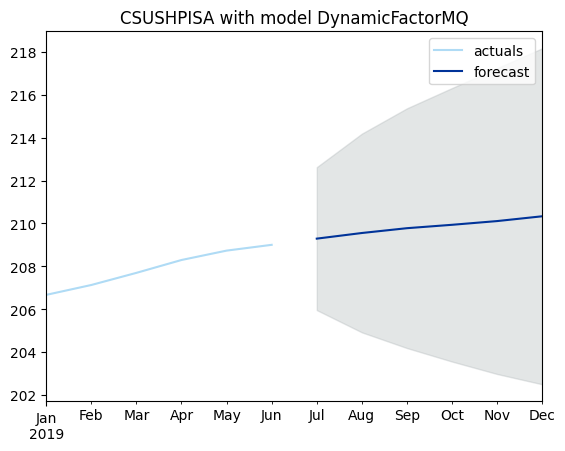

In [15]:
# plot a sample
prediction.plot(model.df_wide_numeric,
                series=model.df_wide_numeric.columns[0],
                start_date="2019-01-01")


In [21]:
# Print the details of the best model
type(model)

autots.evaluator.auto_ts.AutoTS

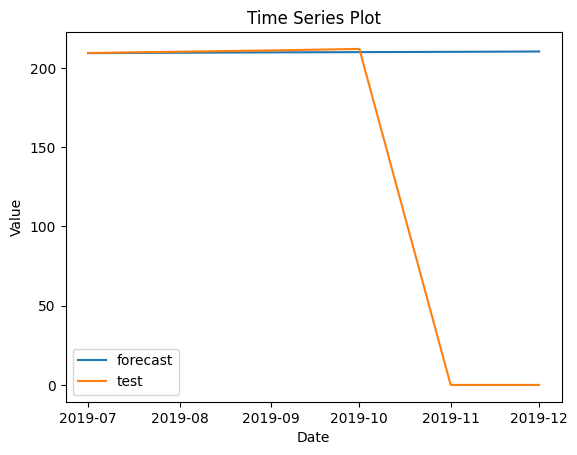

In [16]:
# point forecasts dataframe
forecasts_df = prediction.forecast
plt.plot(forecasts_df.index, forecasts_df['CSUSHPISA'], label='forecast')
plt.plot(df_test.index, df_test['CSUSHPISA'], label='test')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

### model result reading

In [17]:
print(model.best_model_per_series_mape())
print(model.best_model_per_series_score())
print(model.best_model_params)

Series
USEPUINDXM      46.75
EMVOVERALLEMV   40.13
MCOILWTICO      20.85
T10YIEM         14.35
GS10             3.44
EXCHUS           2.65
EXCAUS           1.68
EXUSEU           1.16
CSUSHPISA        0.45
Name: MAPE, dtype: float64
CSUSHPISA       27.61
USEPUINDXM      26.91
EMVOVERALLEMV   22.31
MCOILWTICO      22.17
GS10            22.16
EXCHUS          14.62
EXCAUS          12.40
T10YIEM         10.66
EXUSEU           8.39
dtype: float64
{'model_name': 'Horizontal', 'model_count': 9, 'model_metric': 'Score', 'models': {'c7de4333dc1c5a8da5d8c5de4adbd2d5': {'Model': 'FFT', 'ModelParameters': '{"n_harmonics": 100, "detrend": "linear"}', 'TransformationParameters': '{"fillna": "pchip", "transformations": {"0": "PctChangeTransformer", "1": "FFTFilter", "2": "LevelShiftTransformer"}, "transformation_params": {"0": {}, "1": {"cutoff": 0.01, "reverse": false}, "2": {"window_size": 7, "alpha": 3.0, "grouping_forward_limit": 3, "max_level_shifts": 5, "alignment": "last_value"}}}'}, '5f81933f9

In [15]:
model.results()

,ID,Model,ModelParameters,TransformationParameters,TransformationRuntime,FitRuntime,PredictRuntime,TotalRuntime,Ensemble,Exceptions,...,oda_weighted,dwae_weighted,mqae_weighted,ewmae_weighted,uwmse_weighted,smoothness_weighted,wasserstein_weighted,dwd_weighted,TotalRuntimeSeconds,Score
0,5e75ed52611fa9266c855f5876eb8720,AverageValueNaive,"{""method"": ""Mean"", ""window"": null}","{""fillna"": ""fake_date"", ""transformations"": {""0...",0 days 00:00:00.043711,0 days 00:00:00.000155,0 days 00:00:00.000375,0 days 00:00:00.046192,0,NaN,...,0.43,4.71,6.70,31.13,62.43,0.18,5.85,3.10,0.05,28.56
1,4895867382ea9445684b6b64586d224b,AverageValueNaive,"{""method"": ""Mean"", ""window"": null}","{""fillna"": ""mean"", ""transformations"": {""0"": ""C...",0 days 00:00:00.019604,0 days 00:00:00.000163,0 days 00:00:00.000360,0 days 00:00:00.022510,0,NaN,...,0.26,5.54,7.45,35.25,73.97,0.02,6.39,3.40,0.02,31.42
2,d8bd60351c03557d2b76a1f72be762ff,AverageValueNaive,"{""method"": ""Mean"", ""window"": null}","{""fillna"": ""rolling_mean_24"", ""transformations...",0 days 00:00:00.002634,0 days 00:00:00.000144,0 days 00:00:00.000411,0 days 00:00:00.005048,0,NaN,...,0.52,14.88,13.11,60.92,6117.86,0.95,63.02,17.62,0.01,85.51
3,0efff0c958ba514daf496b68ebefd4b3,DatepartRegression,"{""regression_model"": {""model"": ""DecisionTree"",...","{""fillna"": ""mean"", ""transformations"": {""0"": ""C...",0 days 00:00:00.019184,0 days 00:00:00,0 days 00:00:00.004984,0 days 00:00:00.027195,0,NaN,...,0.26,6.60,11.54,58.93,136.39,0.47,7.38,2.81,0.03,47.07
4,1c73070739b6e35d6de9c827b800378c,DatepartRegression,"{""regression_model"": {""model"": ""SVM"", ""model_p...","{""fillna"": ""zero"", ""transformations"": {""0"": ""C...",0 days 00:00:00.021185,0 days 00:00:00,0 days 00:00:00.019301,0 days 00:00:00.928419,0,NaN,...,0.41,9.68,7.87,33.27,1403.93,0.89,56.80,16.33,0.93,58.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,b924240c576e2ffce675a17665b70fc8,SeasonalityMotif,"{""window"": 10, ""point_method"": ""weighted_mean""...","{""fillna"": ""median"", ""transformations"": {""0"": ...",0 days 00:00:00.004208,0 days 00:00:00.000016,0 days 00:00:00.002313,0 days 00:00:00.008080,0,NaN,...,0.48,4.03,4.06,20.05,48.30,0.39,8.85,2.24,0.01,28.54
877,d0a11331ca2807ec6f85277965bc6096,SectionalMotif,"{""window"": 10, ""point_method"": ""weighted_mean""...","{""fillna"": ""rolling_mean_24"", ""transformations...",0 days 00:00:00.002691,0 days 00:00:00.000013,0 days 00:00:00.000547,0 days 00:00:00.004918,0,NaN,...,0.41,3.82,2.72,13.95,20.98,0.42,7.96,3.76,0.00,23.95
878,967c880b000b60b6f38fcddf00decdc6,FBProphet,"{""holiday"": false, ""regression_type"": null, ""g...","{""fillna"": ""ffill"", ""transformations"": {""0"": ""...",0 days 00:00:00.001135,0 days 00:00:00.000010,0 days 00:00:00.846759,0 days 00:00:00.849924,0,NaN,...,0.28,5.91,5.78,27.26,187.94,0.44,17.64,2.77,0.85,41.46
879,68c802f2ac752ca2df517fb9747e95f2,VAR,"{""regression_type"": null, ""maxlags"": null, ""ic...","{""fillna"": ""ffill"", ""transformations"": {""0"": ""...",0 days 00:00:00.045921,0 days 00:00:00.000006,0 days 00:00:00.618926,0 days 00:00:00.667576,0,NaN,...,0.41,4.74,3.86,19.34,69.38,0.50,24.17,3.94,0.67,38.93


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


ValueError('feature_names must be string, and may not contain [, ] or <')


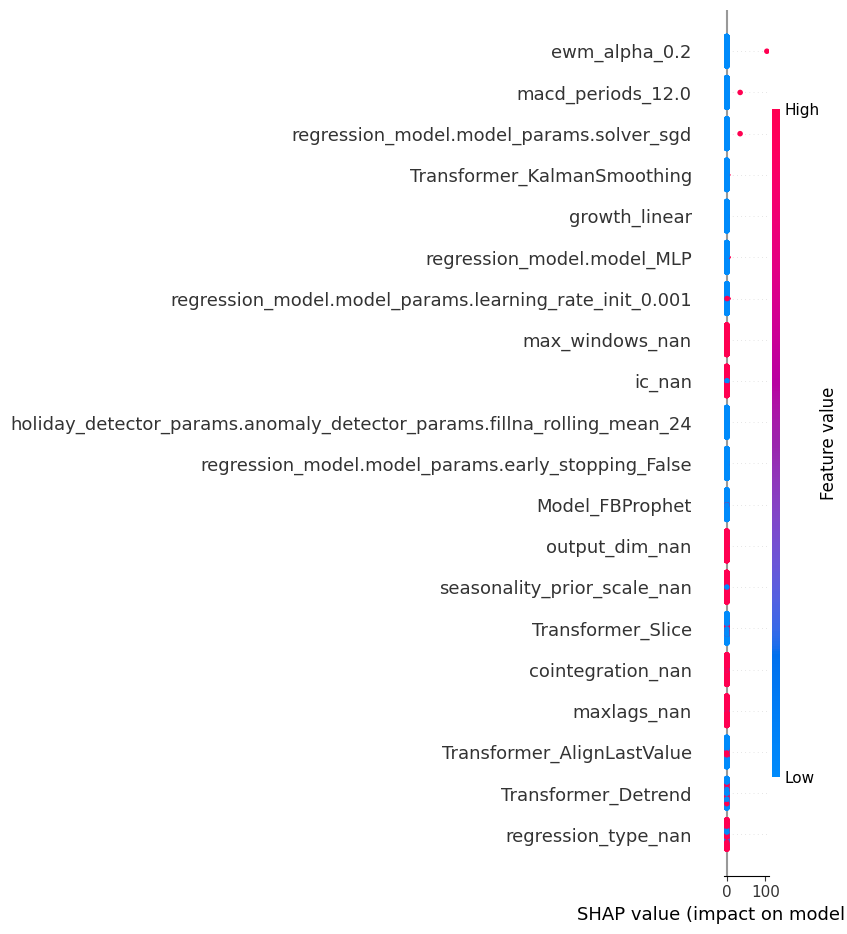

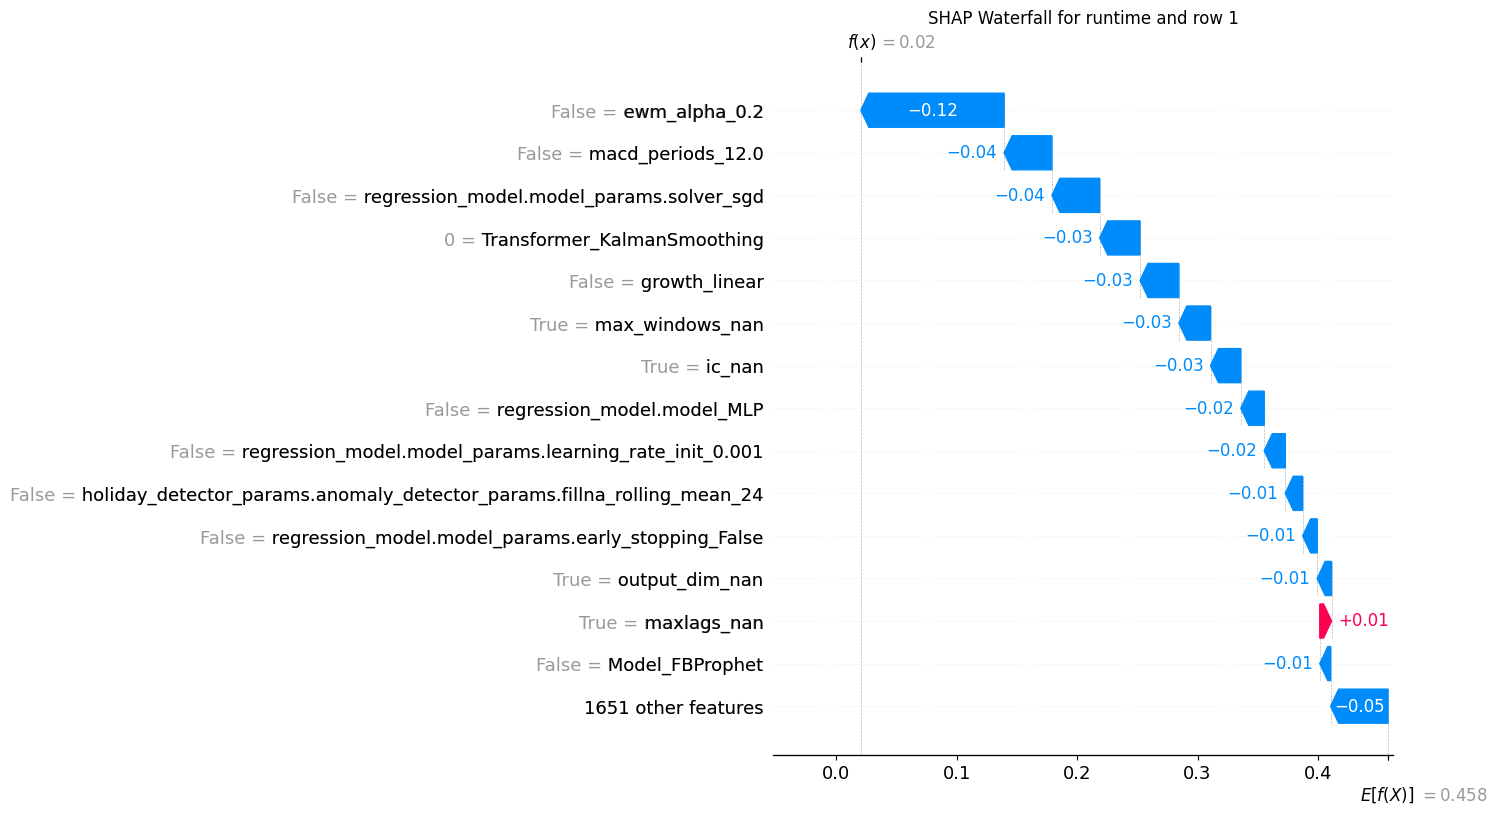

val1 457 and val2 402


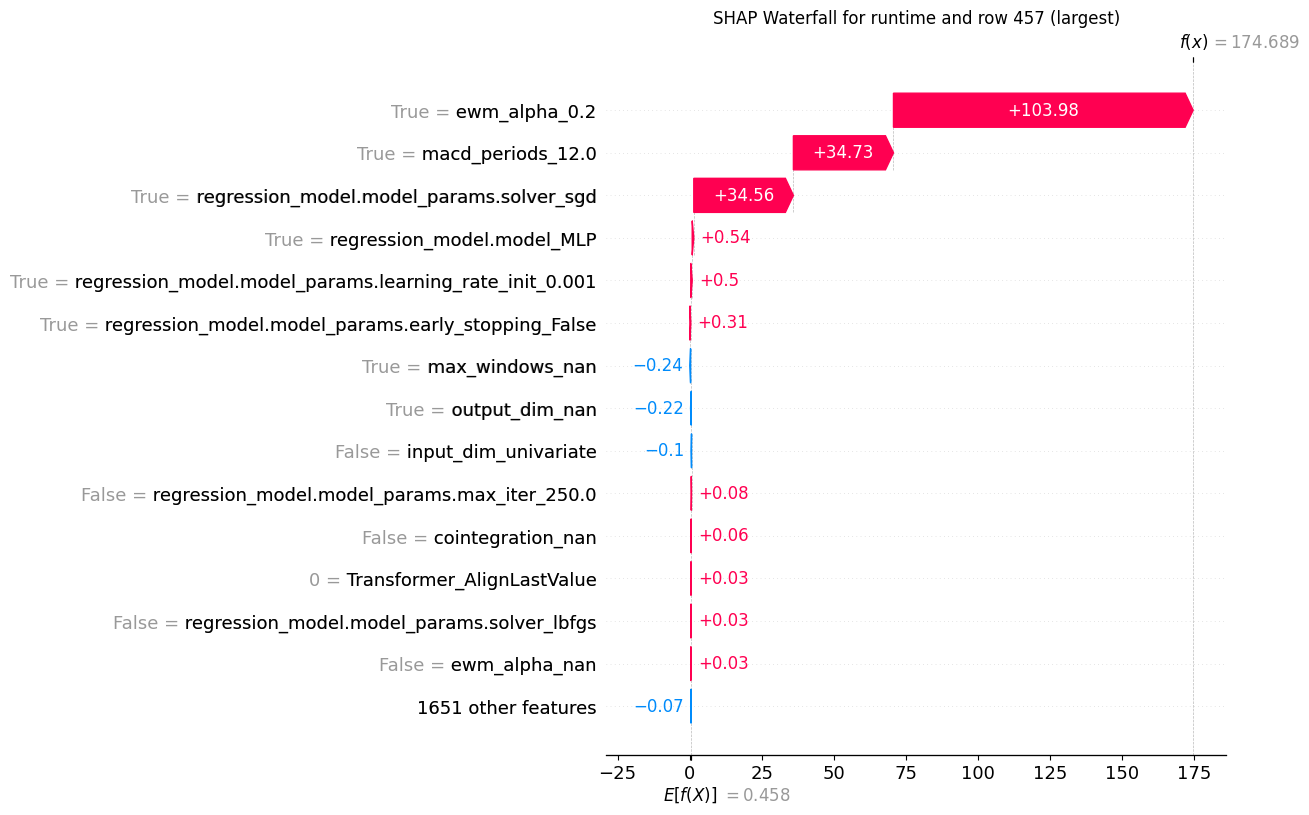

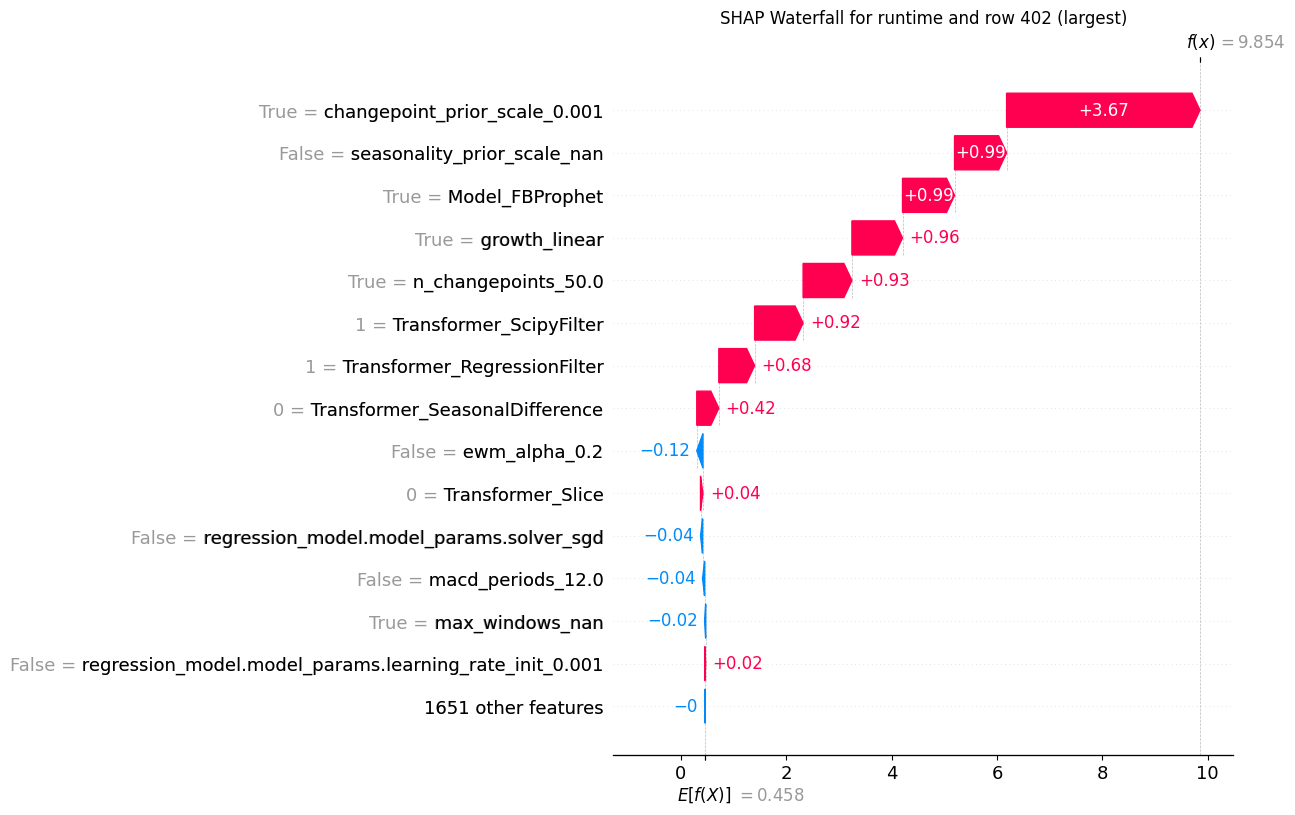

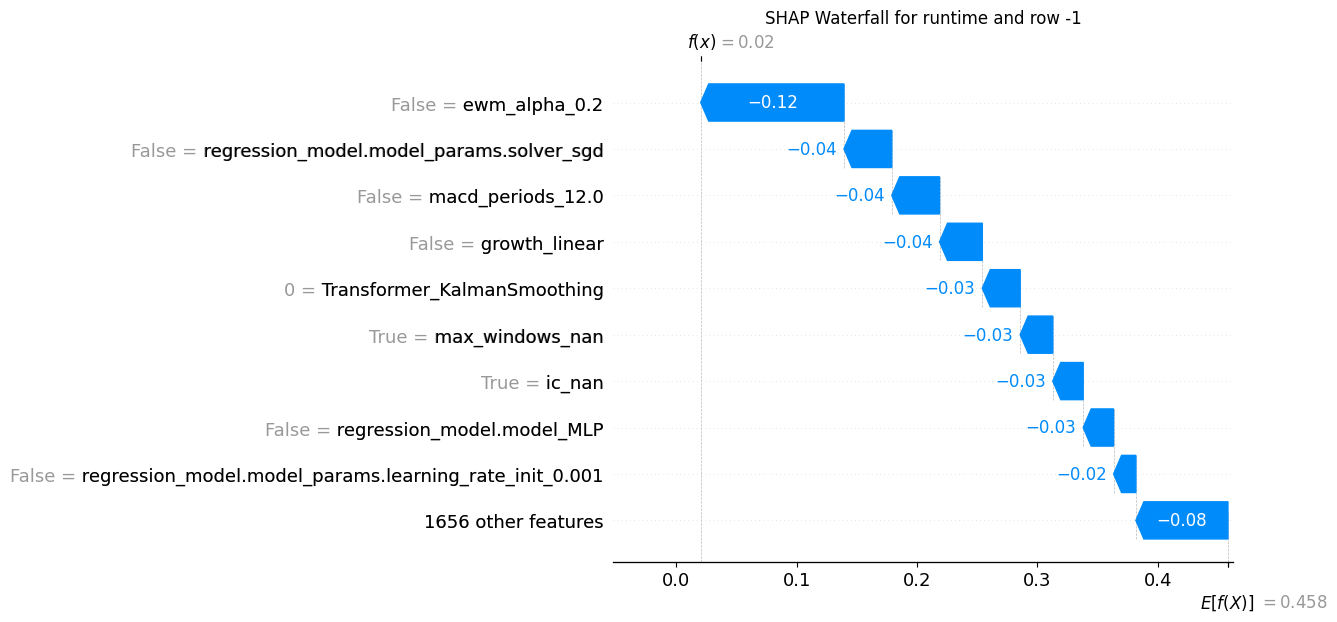

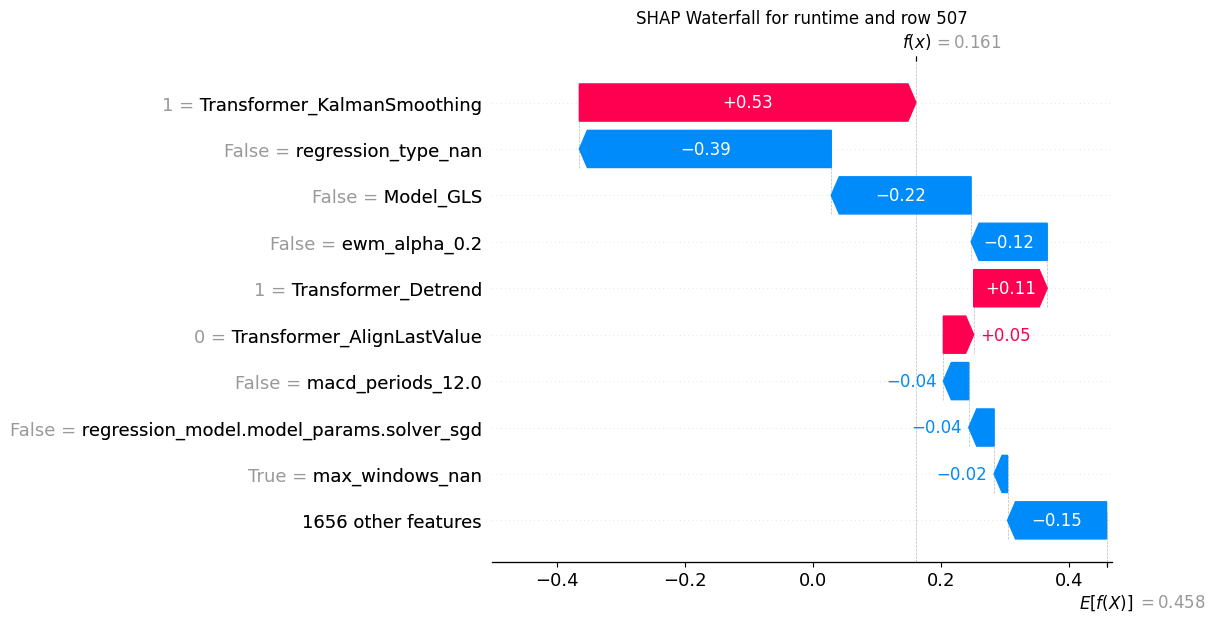

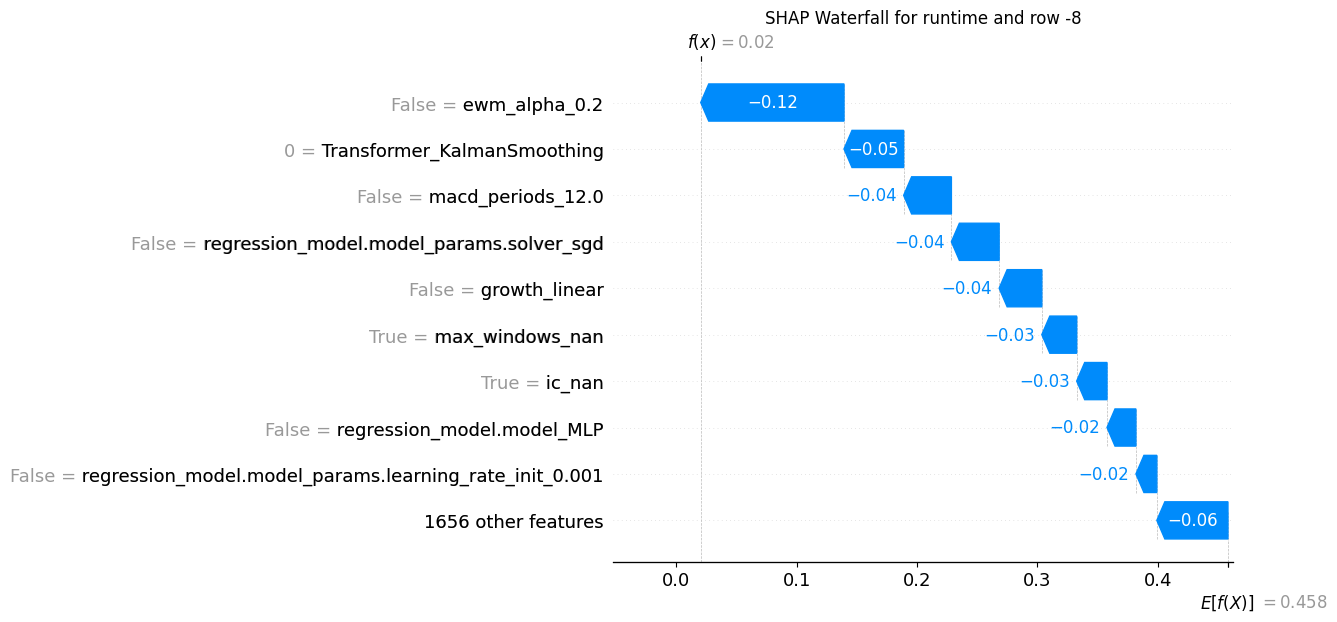

Sorted Lasso Coefficients for Feature Importance:
holiday_detector_params.anomaly_detector_params.fillna_rolling_mean_24: 0.1289
growth_linear: 0.2916
Transformer_KalmanSmoothing: 0.4160
regression_model.model_params.max_iter_1000.0: 0.5175
regression_model.model_params.activation_relu: 0.5210
macd_periods_12.0: 0.5850
ewm_alpha_0.2: 0.6053
window_size_20.0: 0.6233
regression_model.model_params.hidden_layer_sizes_[72, 36, 72]: 1.6882
regression_model.model_params.solver_sgd: 159.2538


,runtime_shap_value,runtime_lasso_value,runtime_elastic_value
method_Exp_Weighted_Mean,0.00,-0.00,-0.00
method_Mean,0.00,-0.00,-0.00
method_Median,0.00,-0.00,-0.00
method_Midhinge,0.00,-0.00,-0.00
method_Weighted_Mean,0.00,-0.00,-0.00
...,...,...,...
Transformer_ReplaceConstant,0.00,0.00,-0.00
Transformer_AlignLastDiff,-0.00,0.00,0.00
Transformer_DiffSmoother,0.00,-0.00,-0.00
Transformer_HistoricValues,0.00,-0.00,-0.00


In [18]:
model.diagnose_params()

### Accuracy metrics

In [11]:
def forecast_accuracy(forecast, actual):
    forecast,actual= np.array(forecast), np.array(actual) 
    try:
        mape = np.mean(np.abs((actual - forecast) / actual))*100
    except:
        mape = 200 # MAPE
    mae = mean_absolute_error(actual,forecast)    # MAE
    rmse = (mean_squared_error(actual,forecast))**.5  # RMSE
#     MASE=mase(actual,forecast)
    r2=r2_score(actual,forecast)                   # r-squared
    rtae=(mean_absolute_error(actual,forecast)/np.mean(abs(actual)))
    return({'mape':mape, 'mae': mae, 
            'rmse':rmse,
             'r2':r2,
            'rtae':rtae
           })

### multi collinearity 

In [35]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
X = data[['variable1', 'variable2', 'variable3', ...]]
corr_matrix = X.corr()
print(corr_matrix)  

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in
 
range(X.shape[1])]
vif["Feature"] = X.columns
print(vif)  # Look for VIF values above 5 or 10

### co integration

In [28]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

In [29]:
res=coint_johansen(df_train.values,det_order=1,k_ar_diff=1)

In [32]:
print(res.lr1)

[391.85900721 205.79517096 126.00846703  89.23417867  58.29375911
  38.44314963  20.63957279  10.05434181   4.11609295]


In [34]:
print(res.lr2)
print(res.evec)

[186.06383625  79.78670393  36.77428835  30.94041957  19.85060947
  17.80357684  10.58523099   5.93824885   4.11609295]
[[ 1.97241978e-02 -5.01741614e-03  1.63279211e-02 -2.67821419e-02
  -3.52942959e-03  1.72451232e-03  5.26293393e-02  1.85990188e-02
   3.48338342e-02]
 [-2.50346654e-01 -5.64425043e-02  1.66826388e-02  3.12489638e-02
   1.00873588e-02  9.04124510e-03  4.88996620e-03 -8.93665961e-03
  -1.14016136e-02]
 [ 6.29570945e-01 -1.45593807e-01 -1.51508034e+00  1.31295924e+00
  -1.19155834e+00 -2.69519399e+00  3.33664930e+00  8.06773596e-01
  -1.65935282e+00]
 [ 3.31946241e-01  3.59050736e-03 -3.41450748e-01  1.00029341e-01
   2.80375825e-01  1.35099069e-01 -1.66898474e-01 -6.48570386e-01
  -6.74020932e-02]
 [ 1.23976972e+00  1.86375582e+00  2.81435816e+00 -1.80729134e+00
   2.49838668e+00 -1.76304499e+00  6.59365108e-02 -5.81907874e-01
  -2.26704748e+00]
 [ 3.19575743e-02 -8.16969649e-02  7.63322468e-02 -5.68766438e-01
   2.01120111e-01  3.09238454e-01  1.39694625e-01 -5.491272